<a href="https://colab.research.google.com/github/mhoangvslev/FedShop/blob/main/Realistic_Synthetic_Federated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FedShop : The Federated Shop Benchmark

FedShop is a synthetic RDF Federated Benchmark designed for scalability. It evaluates the performances of SPARQL federated query engines such as FedX ,CostFed, Semagrow, Splendid (etc) when the number of sources grows. FedShop is based on a E-commerce scenario with e-shops and e-rating-sites as in BSBM. Compared to BSBM, each shop and rating-site of FedShop has its own SPARQL endpoint and share a common catalog of products. Following the BSBM idea, the FedShop queries simulates a user navigating the Federated shop as a single virtual shop. The scaling factor is obtained by adding more and more shops and rating-sites within the federation. In FedShop, we are able to observe the performances of federated queries when the number of source is increasing.

This notebook helps compare the performance of difference Federated Query Engines.

## Basic statistics

- Number of entities per batch and per class:

|class                                                                   |nb_entities_batch0|nb_entities_batch1|nb_entities_batch2|nb_entities_batch3|nb_entities_batch4|nb_entities_batch5|nb_entities_batch6|nb_entities_batch7|nb_entities_batch8|nb_entities_batch9|
|------------------------------------------------------------------------|------------------|------------------|------------------|------------------|------------------|------------------|------------------|------------------|------------------|------------------|
|http://www4.wiwiss.fu-berlin.de/bizer/bsbm/v01/vocabulary/RatingSite    |10                |20                |30                |40                |50                |60                |70                |80                |90                |100               |
|http://www4.wiwiss.fu-berlin.de/bizer/bsbm/v01/vocabulary/Review        |38019             |91491             |140311            |191293            |237941            |294250            |350990            |410791            |460314            |510378            |
|http://www4.wiwiss.fu-berlin.de/bizer/bsbm/v01/vocabulary/Vendor        |10                |20                |30                |40                |50                |60                |70                |80                |90                |100               |
|http://www4.wiwiss.fu-berlin.de/bizer/bsbm/v01/vocabulary/Product       |47843             |111555            |168837            |230648            |287426            |352208            |417554            |485339            |543518            |602551            |
|http://www4.wiwiss.fu-berlin.de/bizer/bsbm/v01/vocabulary/Person        |3617              |8036              |12443             |15811             |20734             |25812             |29650             |33799             |37917             |42606             |
|http://www4.wiwiss.fu-berlin.de/bizer/bsbm/v01/vocabulary/Offer         |10692             |22388             |32174             |44415             |55637             |65726             |75932             |85814             |95738             |105971            |
|http://www4.wiwiss.fu-berlin.de/bizer/bsbm/v01/vocabulary/ProductType   |18536             |37552             |56308             |75324             |94167             |113032            |131852            |150600            |169395            |188142            |
|http://www4.wiwiss.fu-berlin.de/bizer/bsbm/v01/vocabulary/Producer      |26535             |57739             |86666             |117644            |147517            |178088            |208786            |239432            |268764            |298152            |
|http://www4.wiwiss.fu-berlin.de/bizer/bsbm/v01/vocabulary/ProductFeature|246546            |538797            |807782            |1096861           |1374432           |1659890           |1946383           |2232466           |2505337           |2780151           |

- Vendor dataset:

|         |batch0     |batch1     |batch2     |batch3     |batch4     |batch5     |batch6     |batch7     |batch8     |batch9     |
|---------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
|nquads         |1286796.0  |1399744.0  |1193447.0  |1457148.0  |1343842.0  |1224493.0  |1237205.0  |1194294.0  |1205240.0  |1234778.0  |
|size           |243520766.0|268190534.0|228593081.0|279167101.0|257450613.0|234594465.0|237148881.0|228806612.0|231010619.0|236543791.0|
|size_simplified|232.24 MB  |255.77 MB  |218.0 MB   |266.23 MB  |245.52 MB  |223.73 MB  |226.16 MB  |218.21 MB  |220.31 MB  |225.59 MB  |


- RatingSite dataset:

|         |batch0     |batch1      |batch2      |batch3      |batch4     |batch5      |batch6      |batch7      |batch8      |batch9      |
|---------------|-----------|------------|------------|------------|-----------|------------|------------|------------|------------|------------|
|nquads         |3933362.0  |5323542.0   |4900144.0   |5092949.0   |4758348.0  |5552637.0   |5580621.0   |5816602.0   |4977142.0   |5026735.0   |
|size           |796172654.0|1090750686.0|1005393263.0|1043087940.0|974537645.0|1136038924.0|1140970890.0|1191884230.0|1020010081.0|1032288124.0|
|size_simplified|759.29 MB  |1.02 GB     |958.82 MB   |994.77 MB   |929.39 MB  |1.06 GB     |1.06 GB     |1.11 GB     |972.76 MB   |984.47 MB   |




# Preliminaries

## Download the benchmark

In [ ]:
!pip install --quiet gdown==4.5.4 --no-cache-dir

In [ ]:
!rm -rf /content/benchmark/ *.zip
!gdown 1mQl8yy3ZKJP7WIncUkvlZW3sKlnpg-w2 -O gen-model.zip
!unzip -oq gen-model.zip
!gdown 1b8VNI1GBD8B-OiT9xylJ3VtVoLuBT6iP -O eval-model.zip
!unzip -oq eval-model.zip

Downloading...
From: https://drive.google.com/uc?id=1b8VNI1GBD8B-OiT9xylJ3VtVoLuBT6iP
To: /content/bsbm.zip
100% 136M/136M [00:03<00:00, 40.2MB/s]


## Dependencies

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
from scipy import stats

def linear_regression(row):
    data = generation_metrics.query(f'`query` == {repr(row["query"])}')
    distinct_slope,  distinct_intercept, _, _, _ = stats.linregress(data['batch'], data['nb_distinct_sources'])
    total_slope,  total_intercept, _, _, _ = stats.linregress(data['batch'], data['total_sources'])
    row["rss_slope"],  _, _, _, _ = stats.linregress(data['batch'], data['relevant_sources_selectivity'])
    row["distinct_slope"] = distinct_slope
    #row["y_distinct"] = distinct_slope * row["batch"] + distinct_intercept
    #row["y_total"] = total_slope * row["batch"] + total_intercept
    row["slope_gap"] = total_slope - distinct_slope
    return row

# Generation

In [ ]:
generation_metrics = pd.read_csv("/content/benchmark/generation/metrics.csv") \
    .sort_values(by=["query", "instance", "batch"])

generation_metrics["instance"] = generation_metrics["instance"].astype(str)
generation_metrics

,query,instance,batch,nb_results,nb_distinct_sources,relevant_sources_selectivity
10,q01,0,0,1,1,0.050000
130,q01,0,1,1,1,0.025000
250,q01,0,2,1,1,0.016667
370,q01,0,3,3,3,0.037500
490,q01,0,4,4,4,0.040000
...,...,...,...,...,...,...
609,q12,9,5,1,1,0.008333
729,q12,9,6,1,1,0.007143
849,q12,9,7,1,1,0.006250
969,q12,9,8,1,1,0.005556


In [ ]:
_, vendors_labels = np.histogram(np.arange(100), generation_metrics["batch"].nunique())
vendors_labels = vendors_labels[1:].astype(int) + 1

_, ratingsite_labels = np.histogram(np.arange(100), generation_metrics["batch"].nunique())
ratingsite_labels = ratingsite_labels[1:].astype(int) + 1

xticks = [ f"{vendor} vendors\n{ratingsite} ratingsites" for vendor, ratingsite in zip(vendors_labels, ratingsite_labels) ]

## Does the number of source have impact on source selectivity?

In [ ]:
selectivity_metrics = "nb_distinct_sources" #@param ["relevant_sources_selectivity", "nb_distinct_sources"]

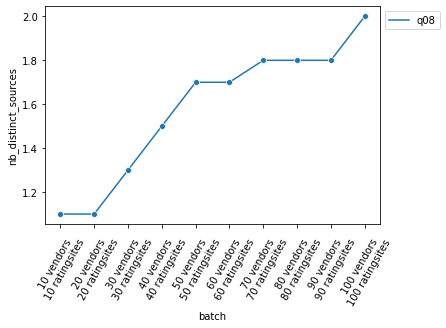

In [ ]:
#@title Line plot showing source selectivity tendency when the number of sources increases

g = sns.lineplot(data=generation_metrics.query("`query` == 'q08'"), x="batch", y=selectivity_metrics, markers=="o", hue="query", ci=None)
g.set_xticks(generation_metrics["batch"].unique())
g.set_xticklabels(xticks, rotation=60)
g.set_yscale("linear")
plt.legend(loc = 2, bbox_to_anchor = (1,1))
plt.show()

In [ ]:
generation_metrics["total_sources"] = generation_metrics["batch"].apply(lambda x: vendors_labels[x] + ratingsite_labels[x])
generation_metrics = generation_metrics.apply(linear_regression, axis=1)
generation_metrics

,query,instance,batch,nb_results,nb_distinct_sources,relevant_sources_selectivity,total_sources,rss_slope,distinct_slope,slope_gap
10,q01,0,0,1,1,0.050000,20,-0.002437,0.466667,19.533333
130,q01,0,1,1,1,0.025000,40,-0.002437,0.466667,19.533333
250,q01,0,2,1,1,0.016667,60,-0.002437,0.466667,19.533333
370,q01,0,3,3,3,0.037500,80,-0.002437,0.466667,19.533333
490,q01,0,4,4,4,0.040000,100,-0.002437,0.466667,19.533333
...,...,...,...,...,...,...,...,...,...,...
609,q12,9,5,1,1,0.008333,120,-0.003703,0.000000,20.000000
729,q12,9,6,1,1,0.007143,140,-0.003703,0.000000,20.000000
849,q12,9,7,1,1,0.006250,160,-0.003703,0.000000,20.000000
969,q12,9,8,1,1,0.005556,180,-0.003703,0.000000,20.000000


In [ ]:
def area_under_curve(data):
    return np.trapz(y=data["y_total"]) - np.trapz(y=data["y_distinct"])

growth = generation_metrics['distinct_slope']
mean_rss_slope = generation_metrics['rss_slope']

- Let $y=a \times x + b$ be the equation of the regression line between `distinct_source` and `batch`.
- The source selectivity is given by: $$\texttt{relevant_source_selection} = \frac{\texttt{distinct_source}}{\texttt{total_source}}$$
- The slope $a$ indicates the growth speed of `distinct_source` w.r.t `total_source`. The more $a$ increases, the faster `distinct_source` grows, then the more `relevant_source_selection` decreases.

In [ ]:
# H0: r = 0 (no corr), H1 r < 0 (neg corr)
stats.spearmanr(
    generation_metrics["distinct_slope"], # faster distinct_sources grows...
    generation_metrics['rss_slope'], # ...lower source selectivity
    alternative="greater"
)

SignificanceResult(statistic=0.9219858156028368, pvalue=0.0)

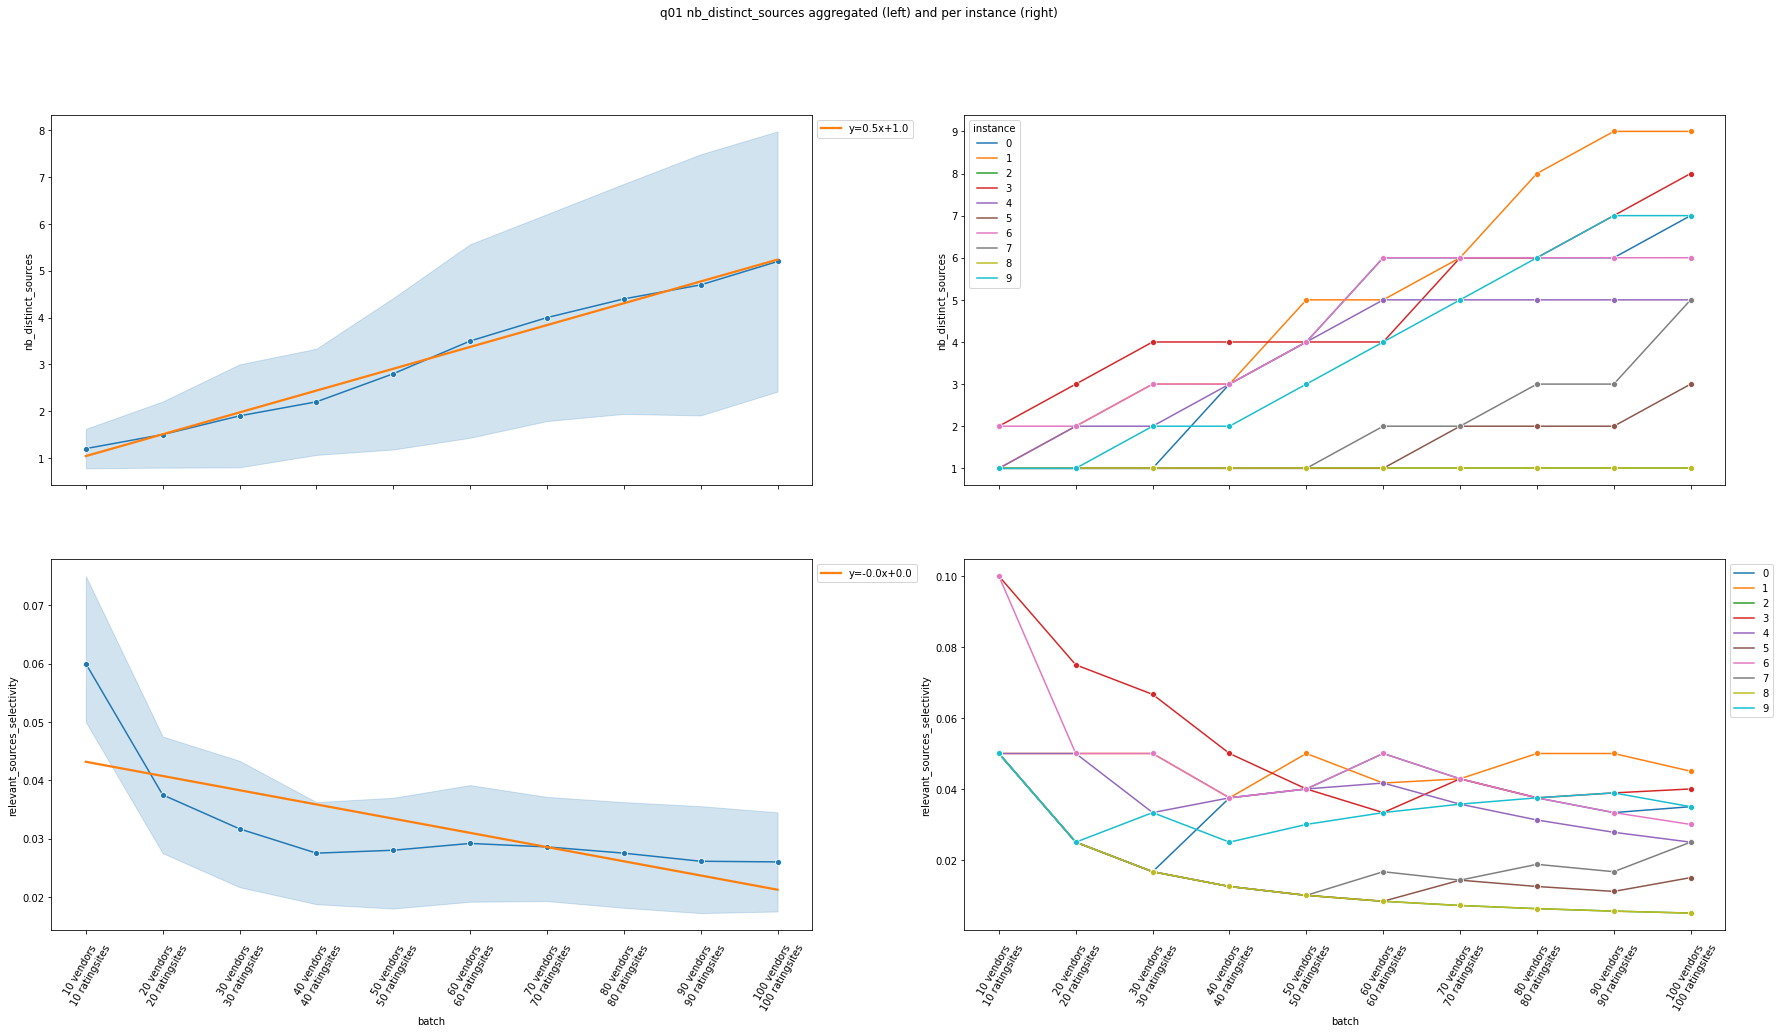

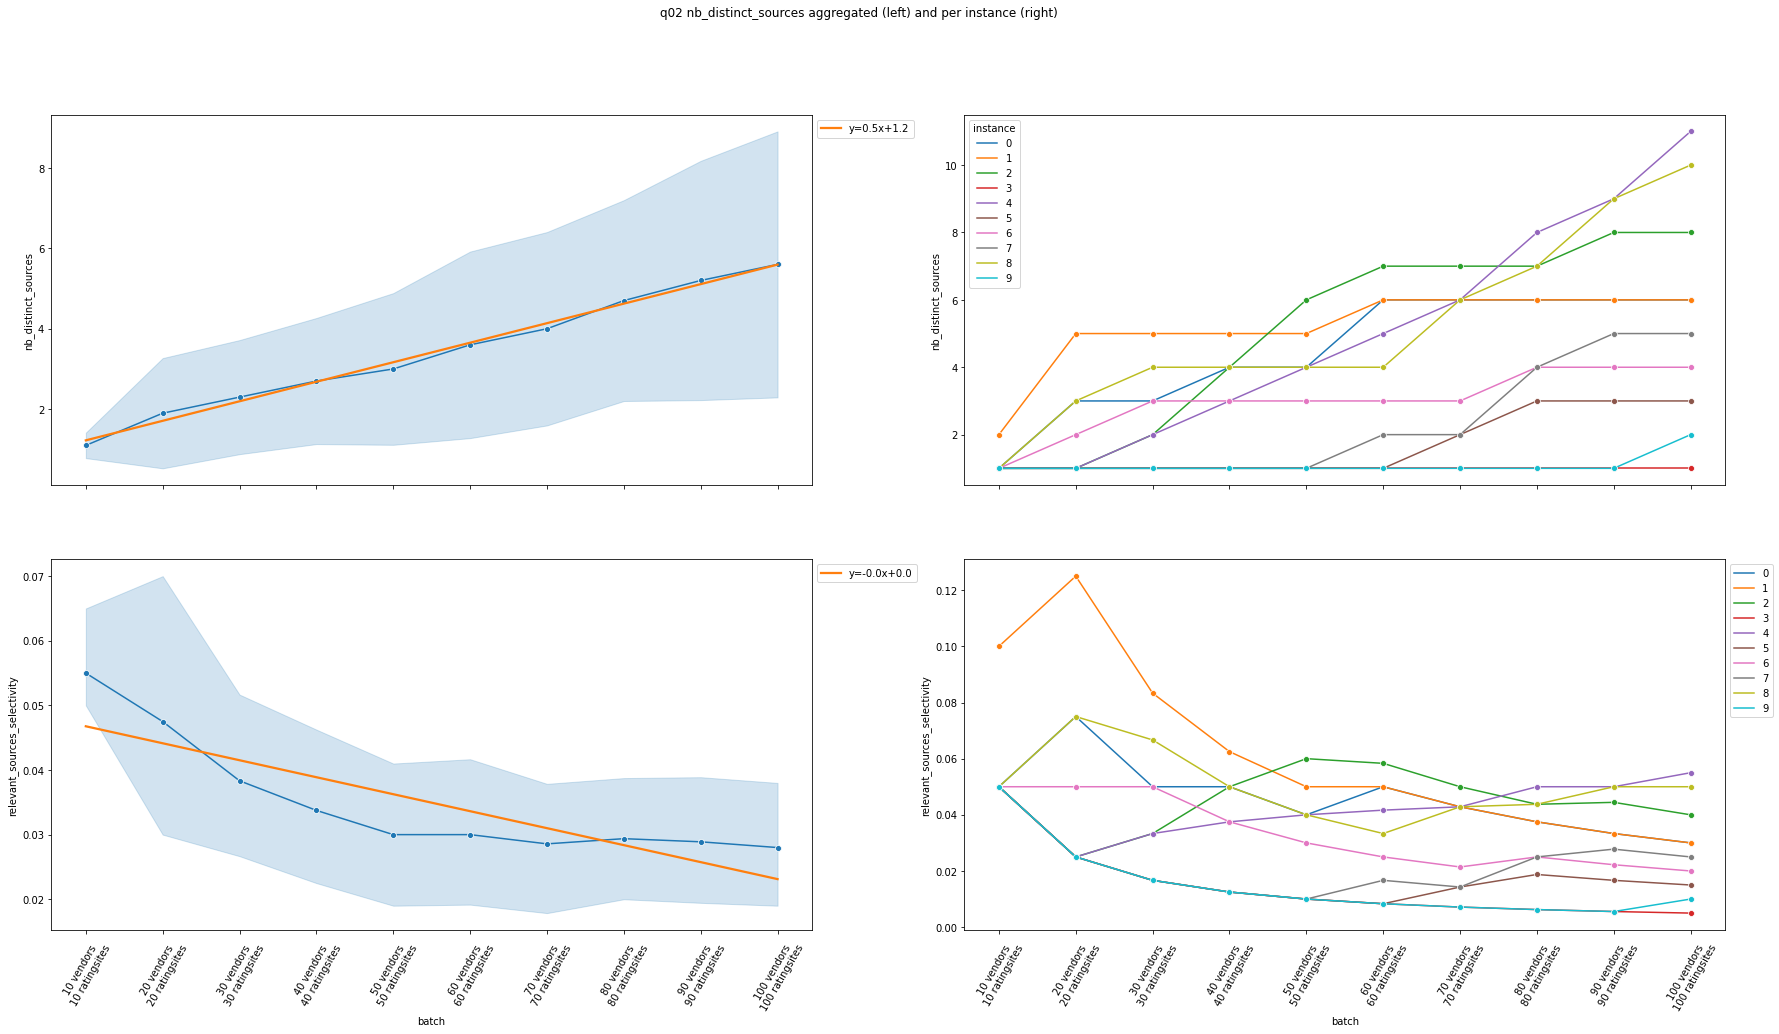

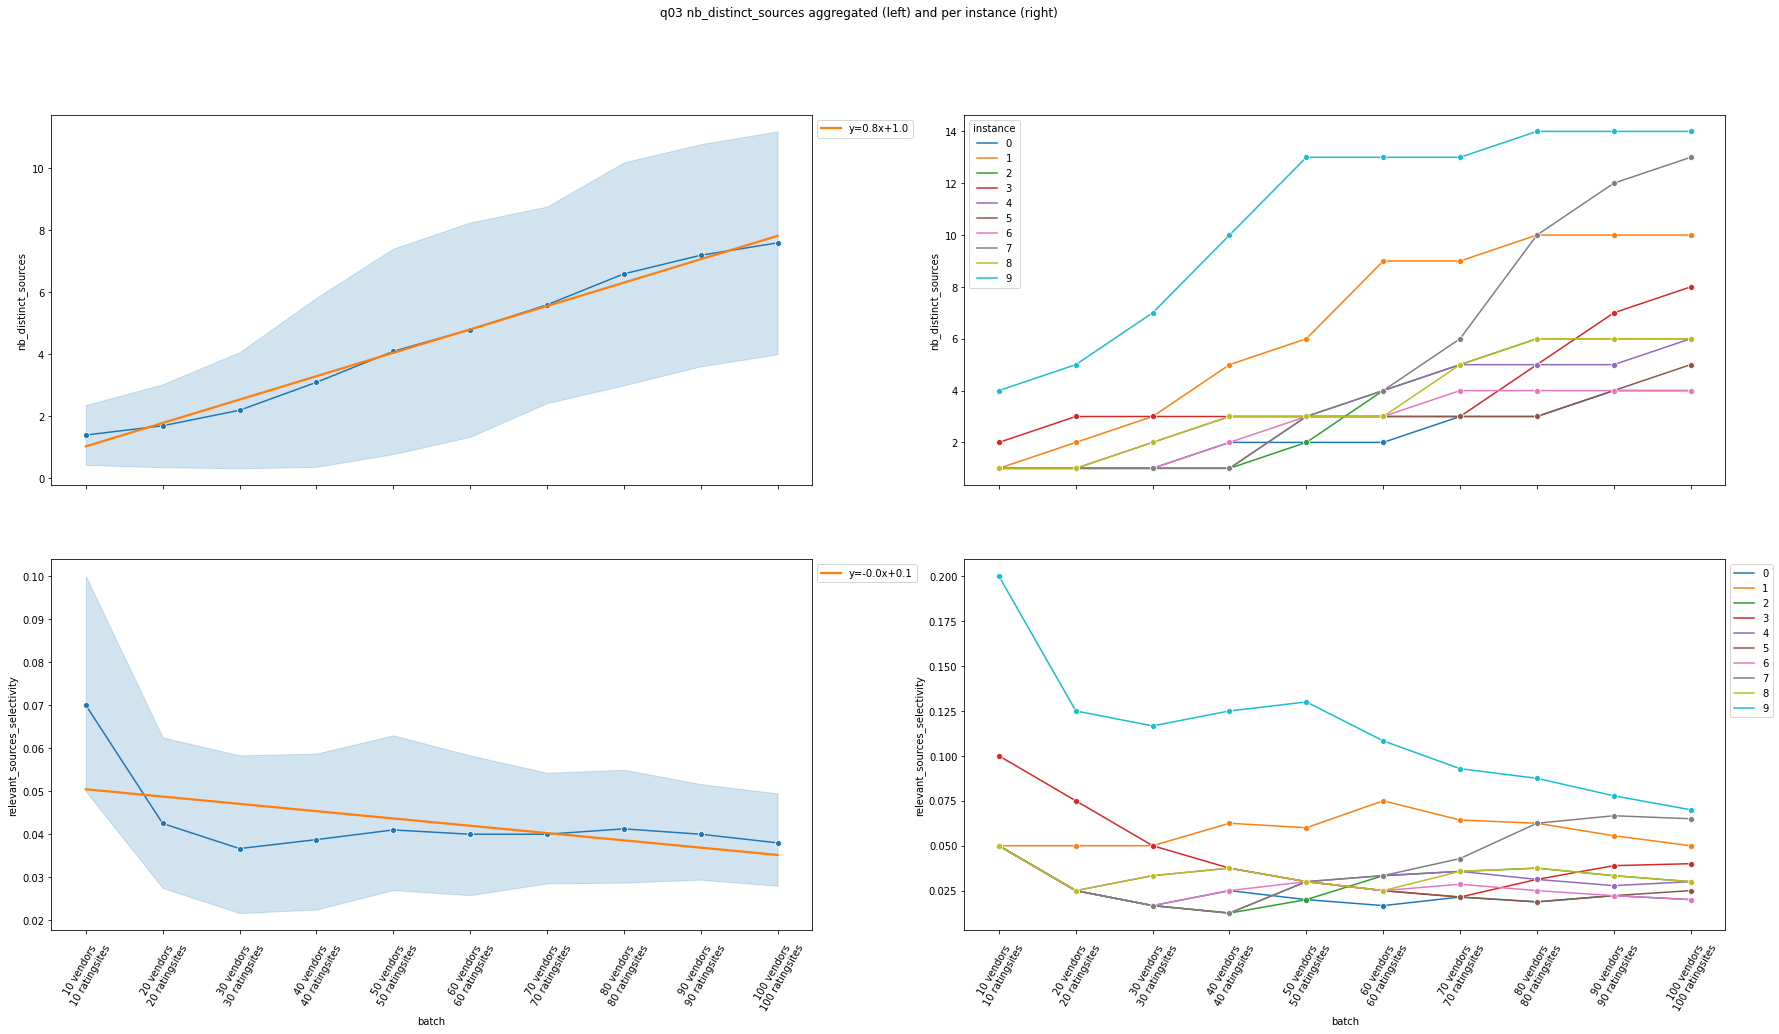

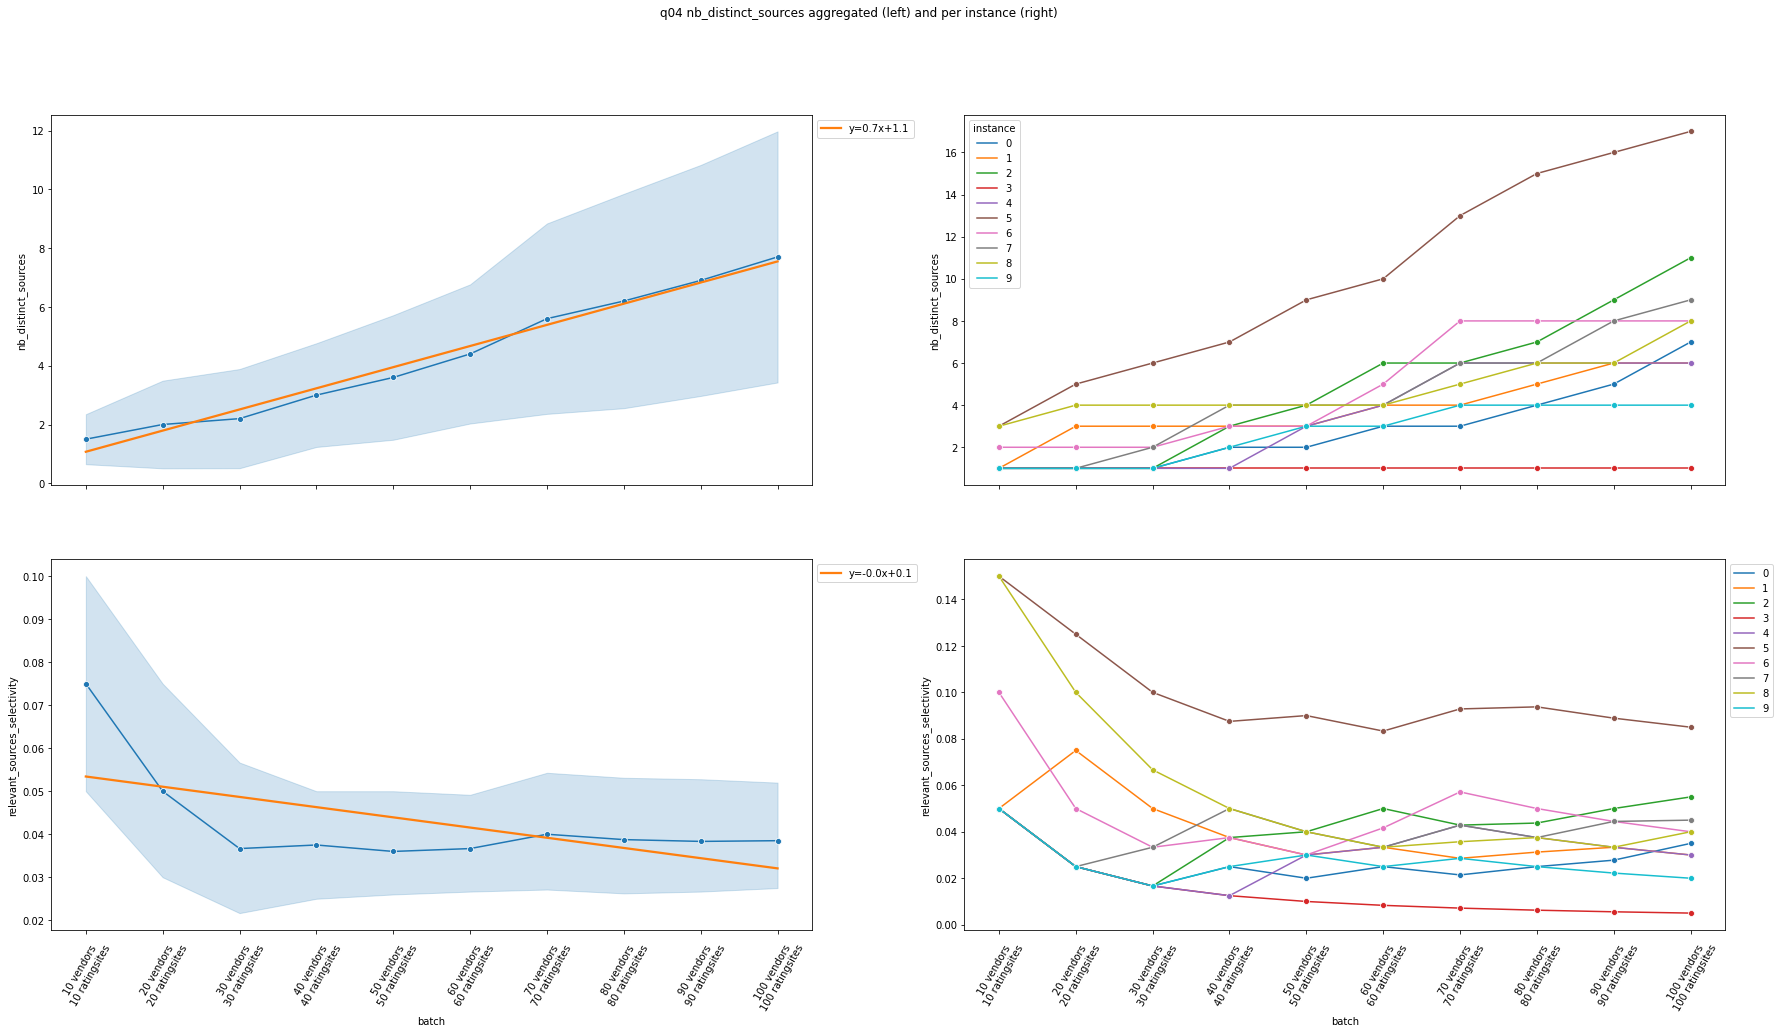

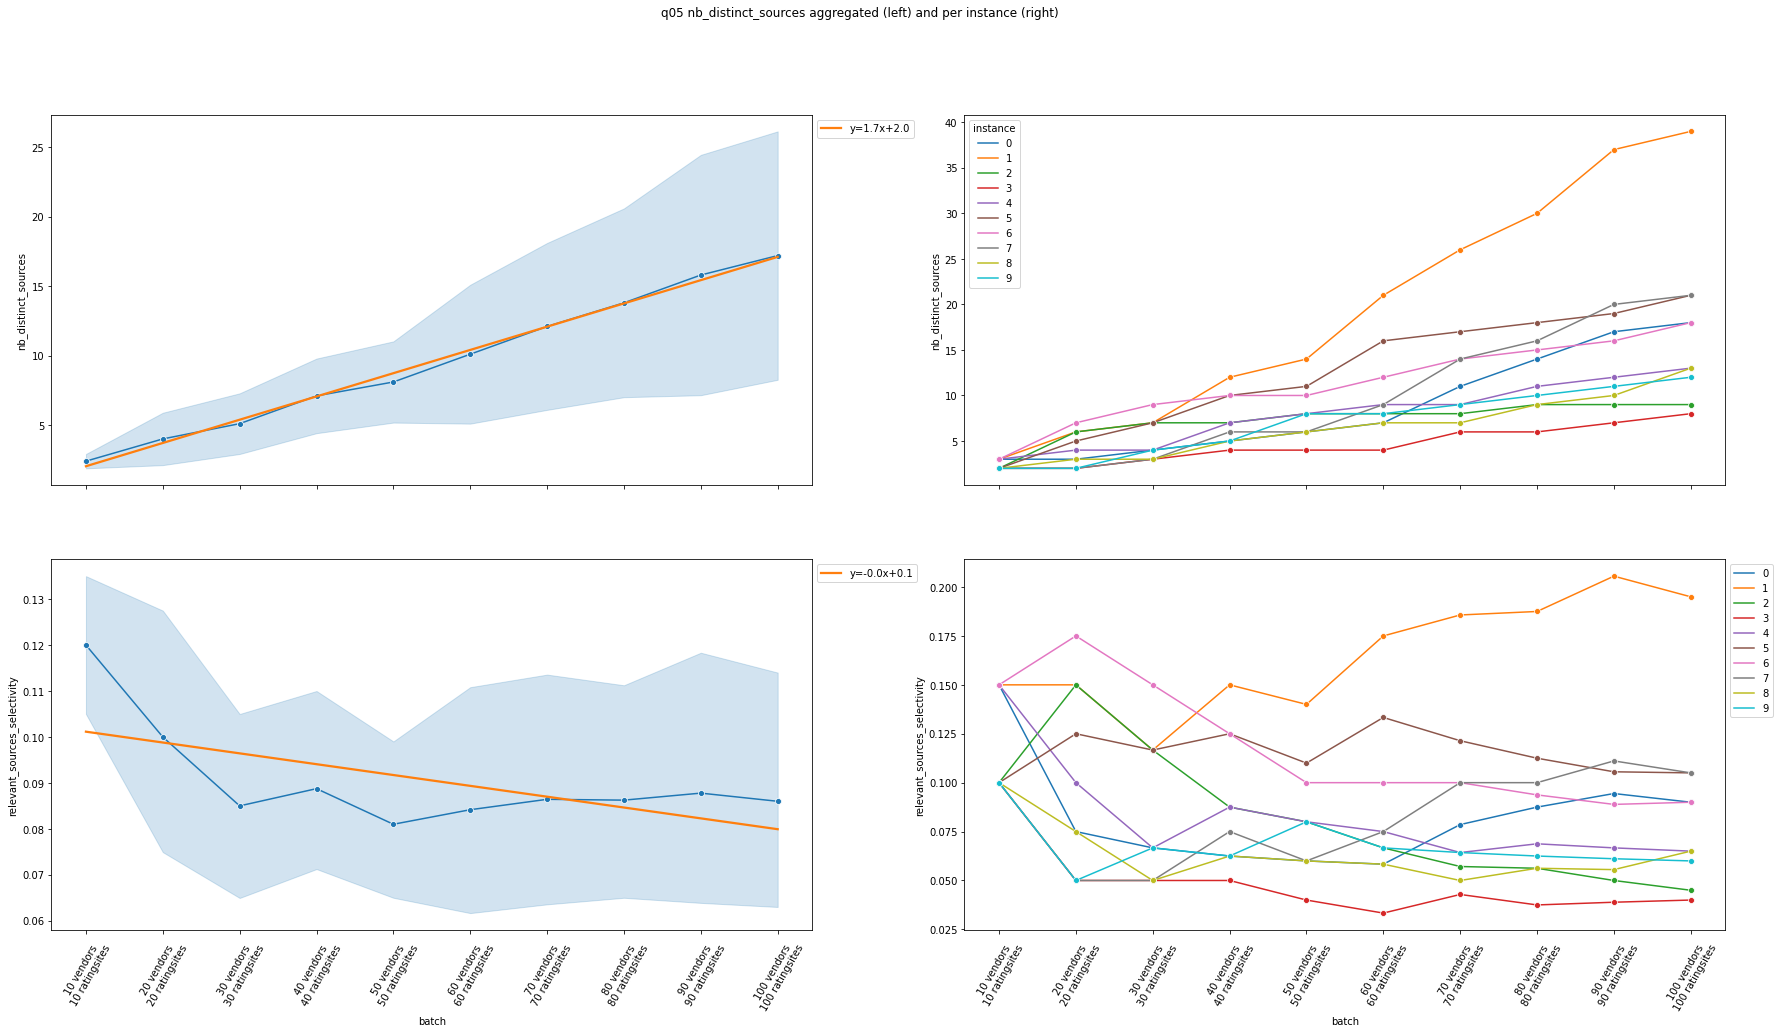

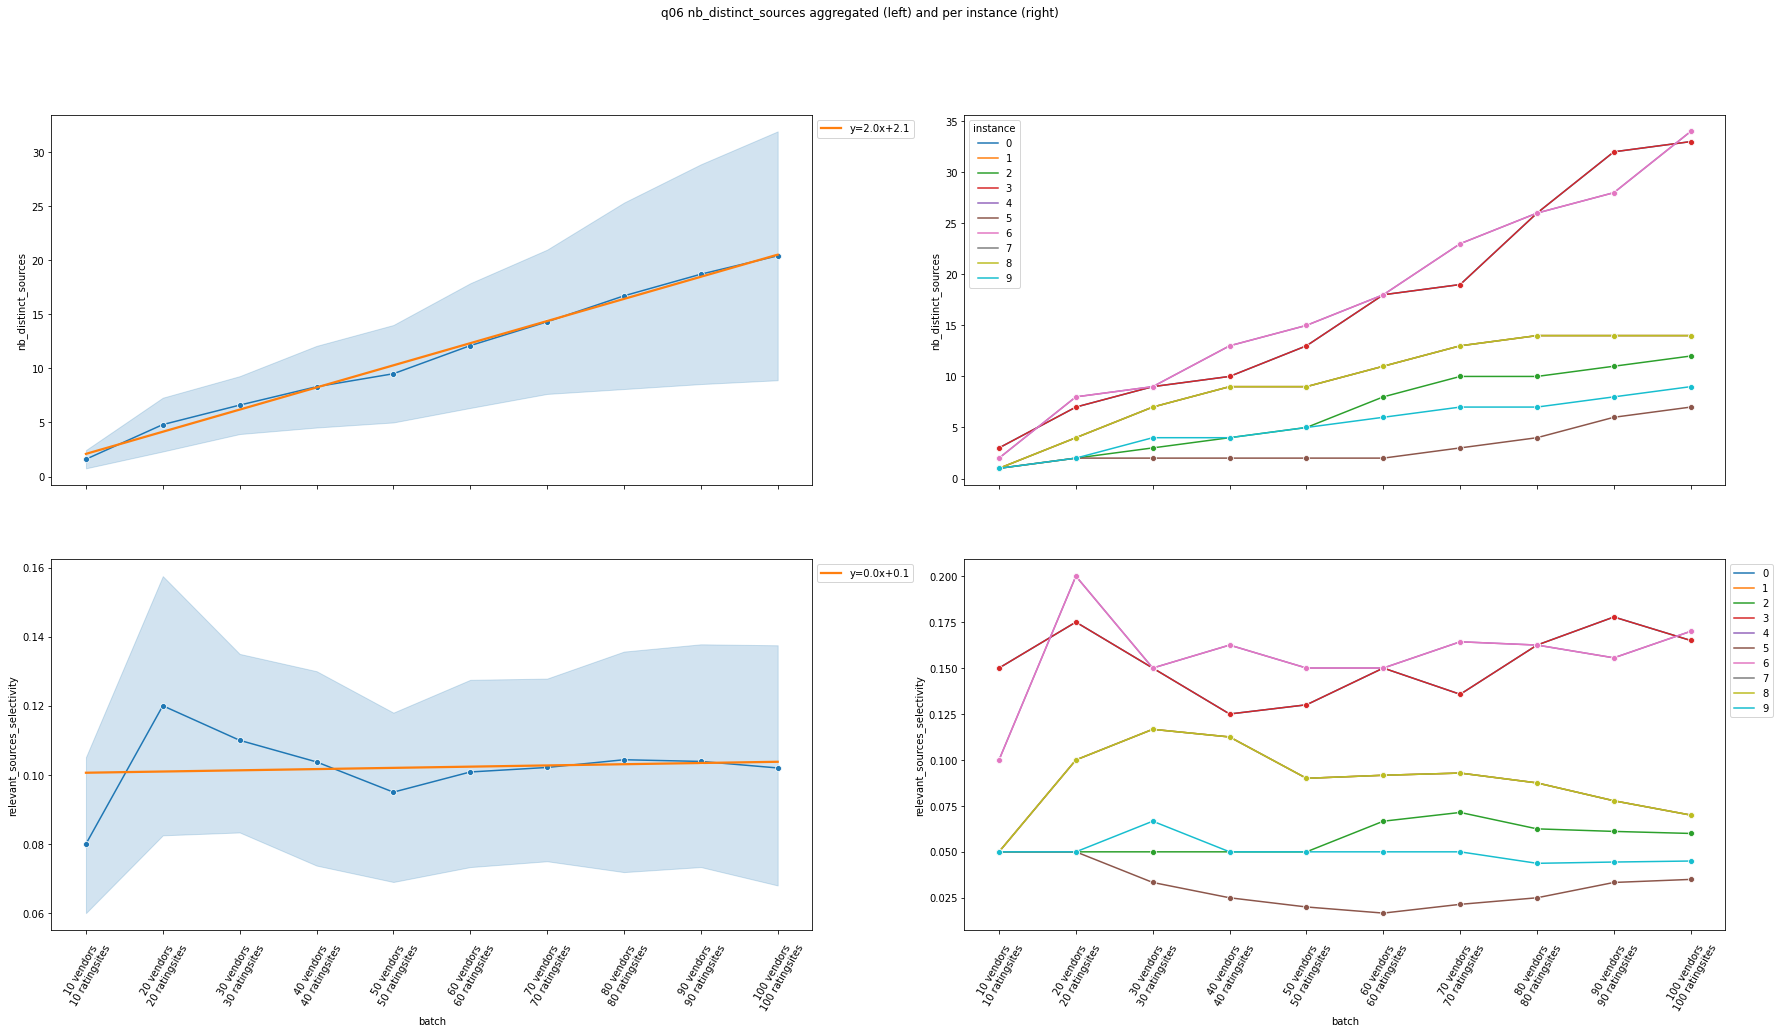

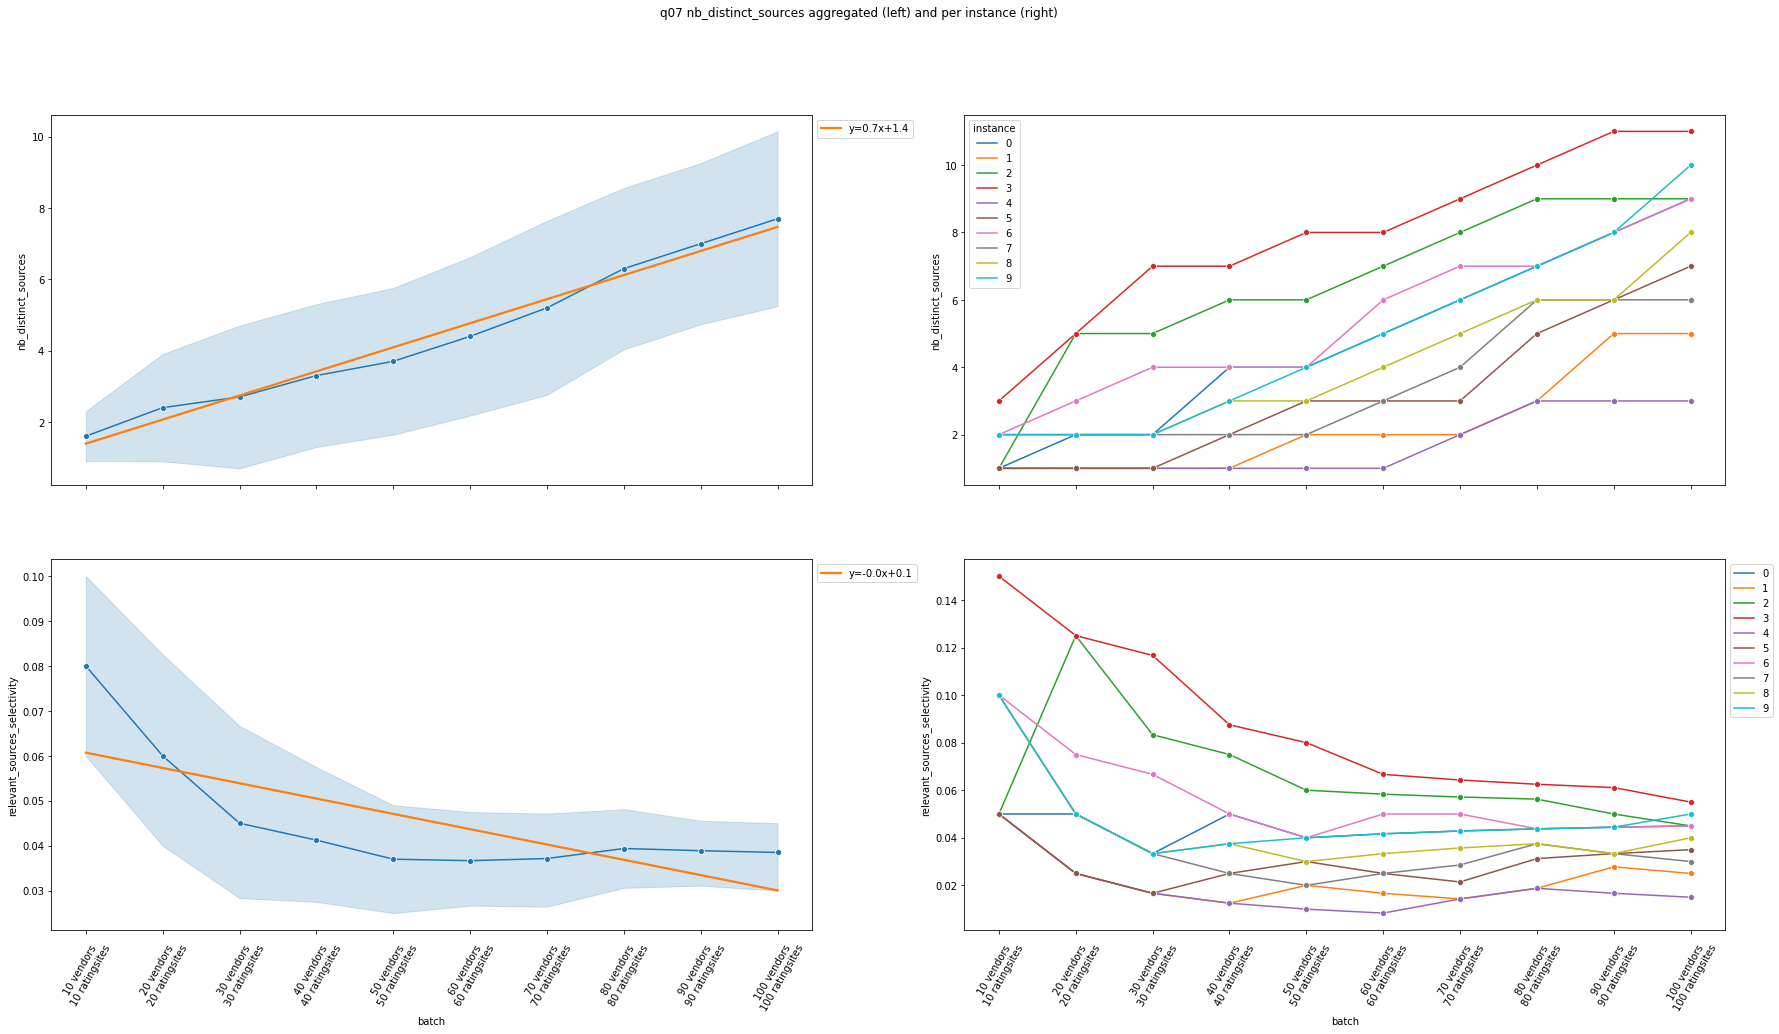

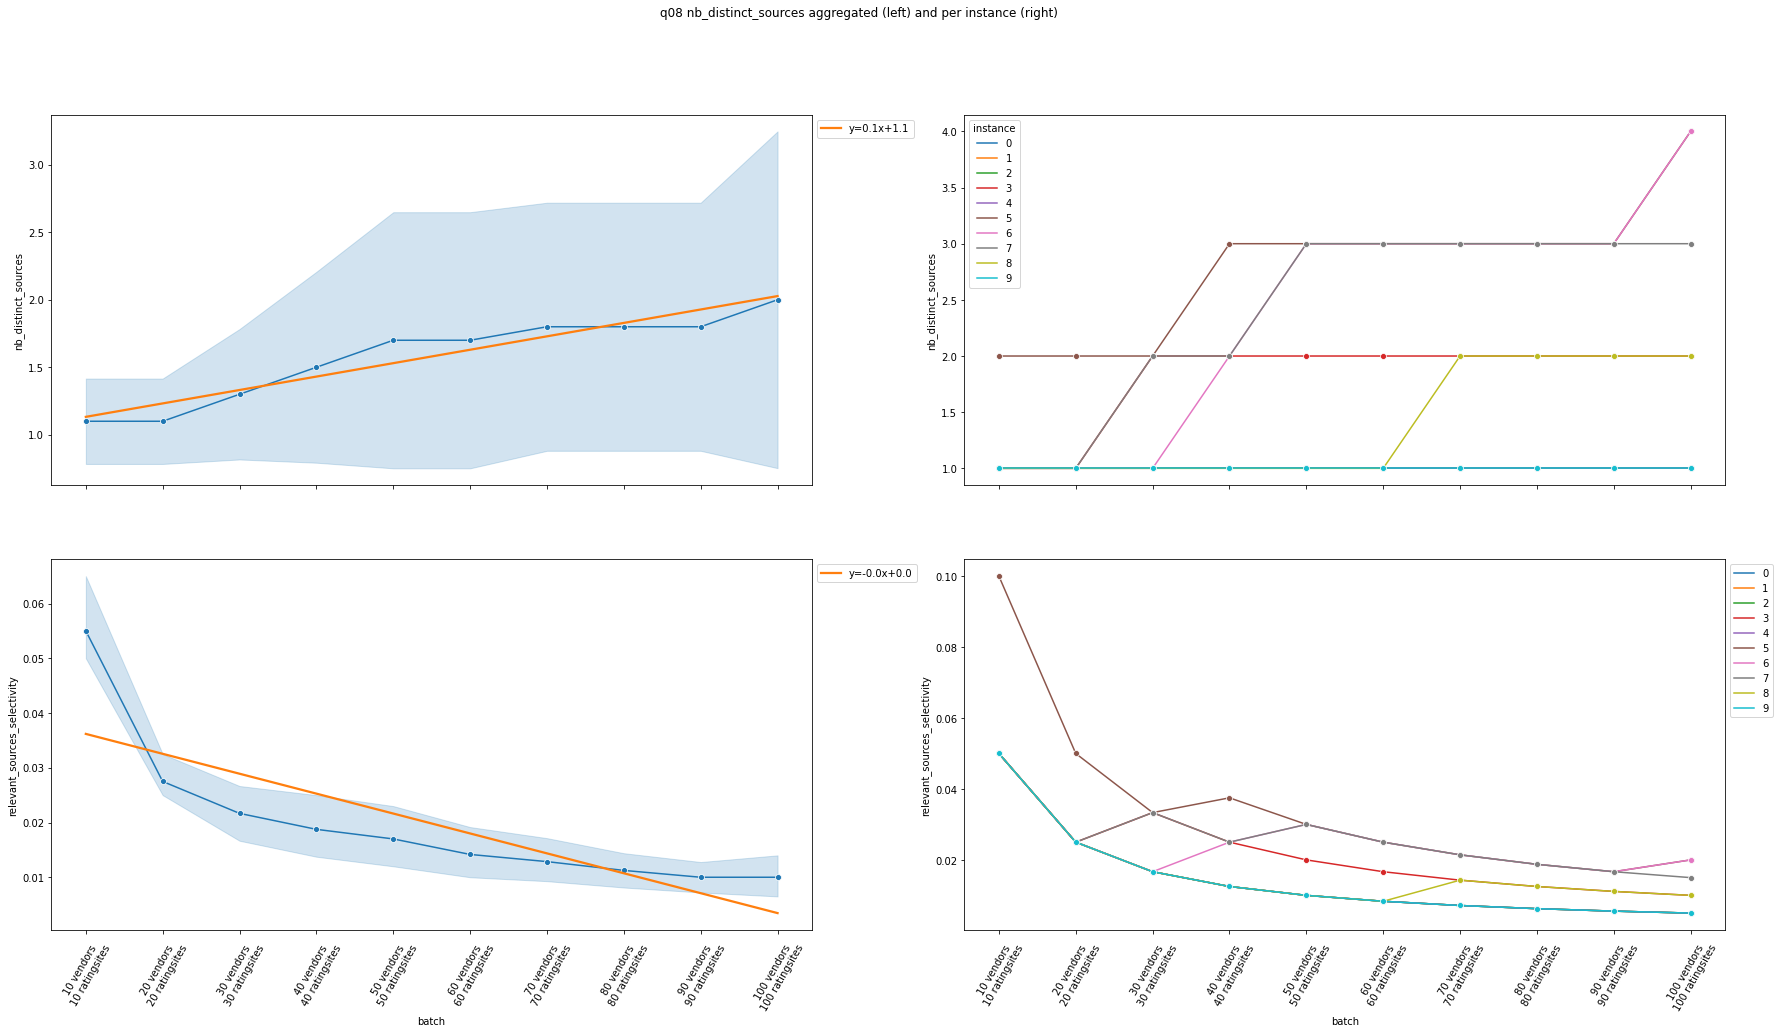

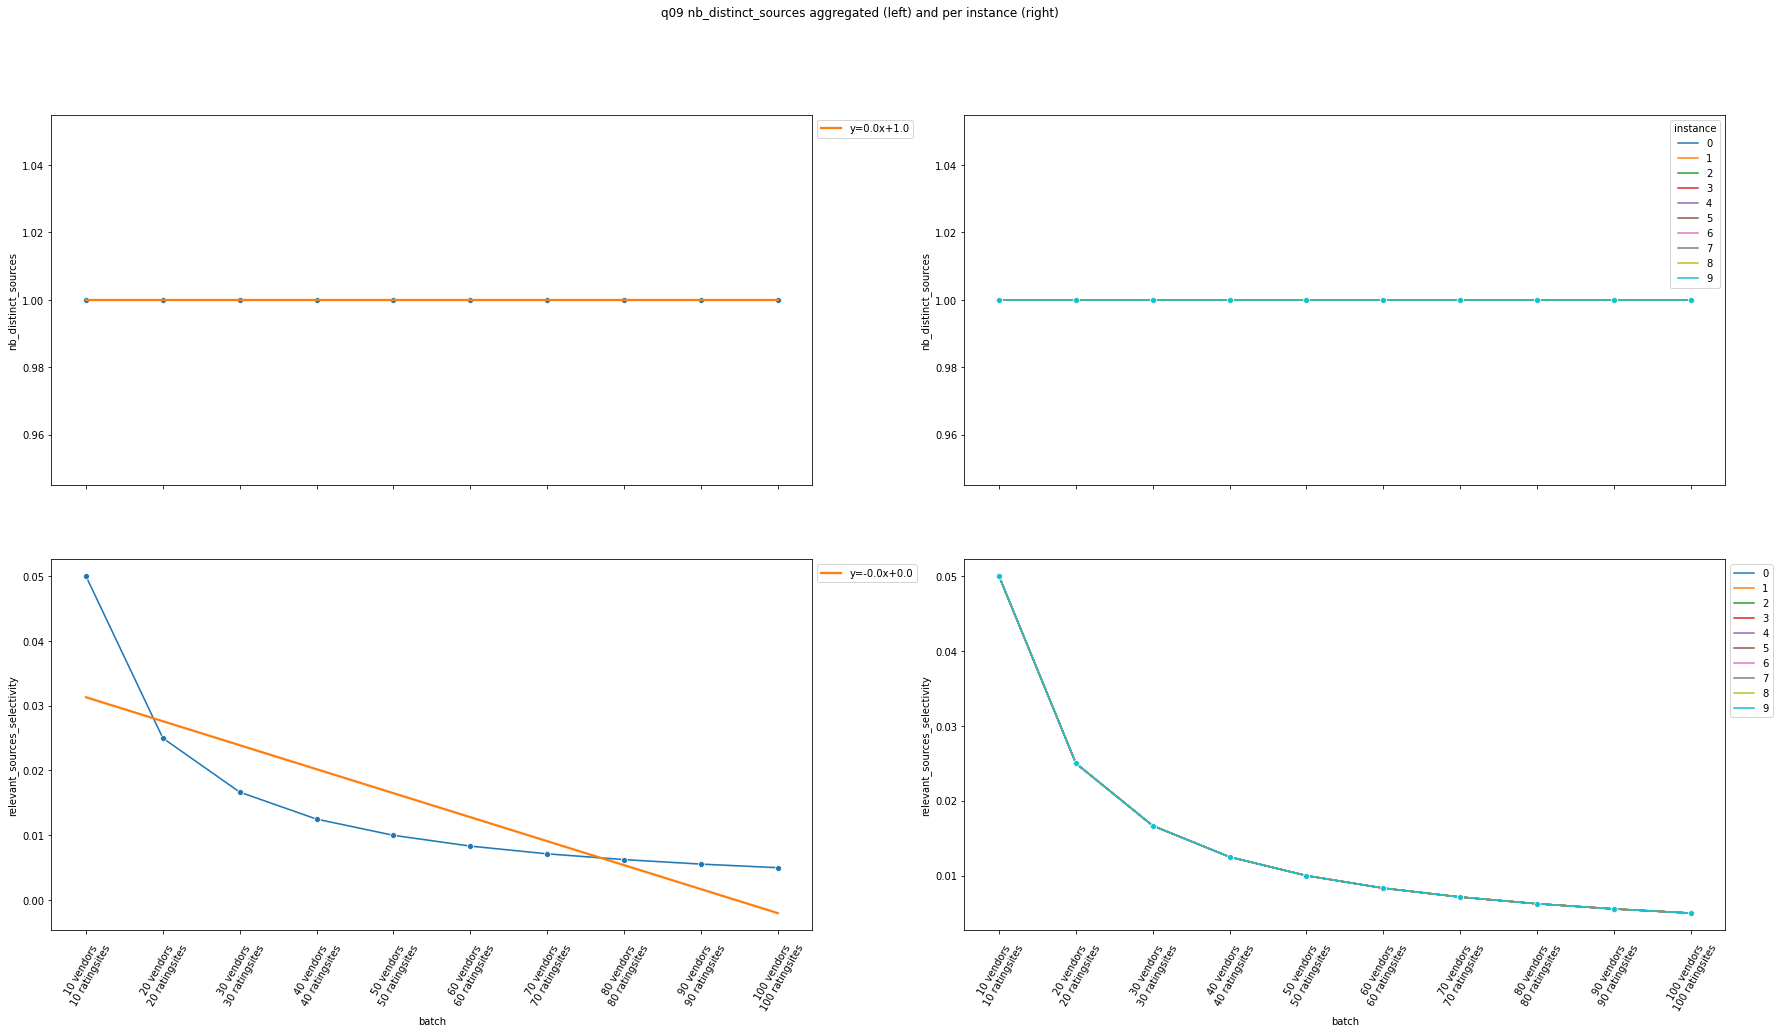

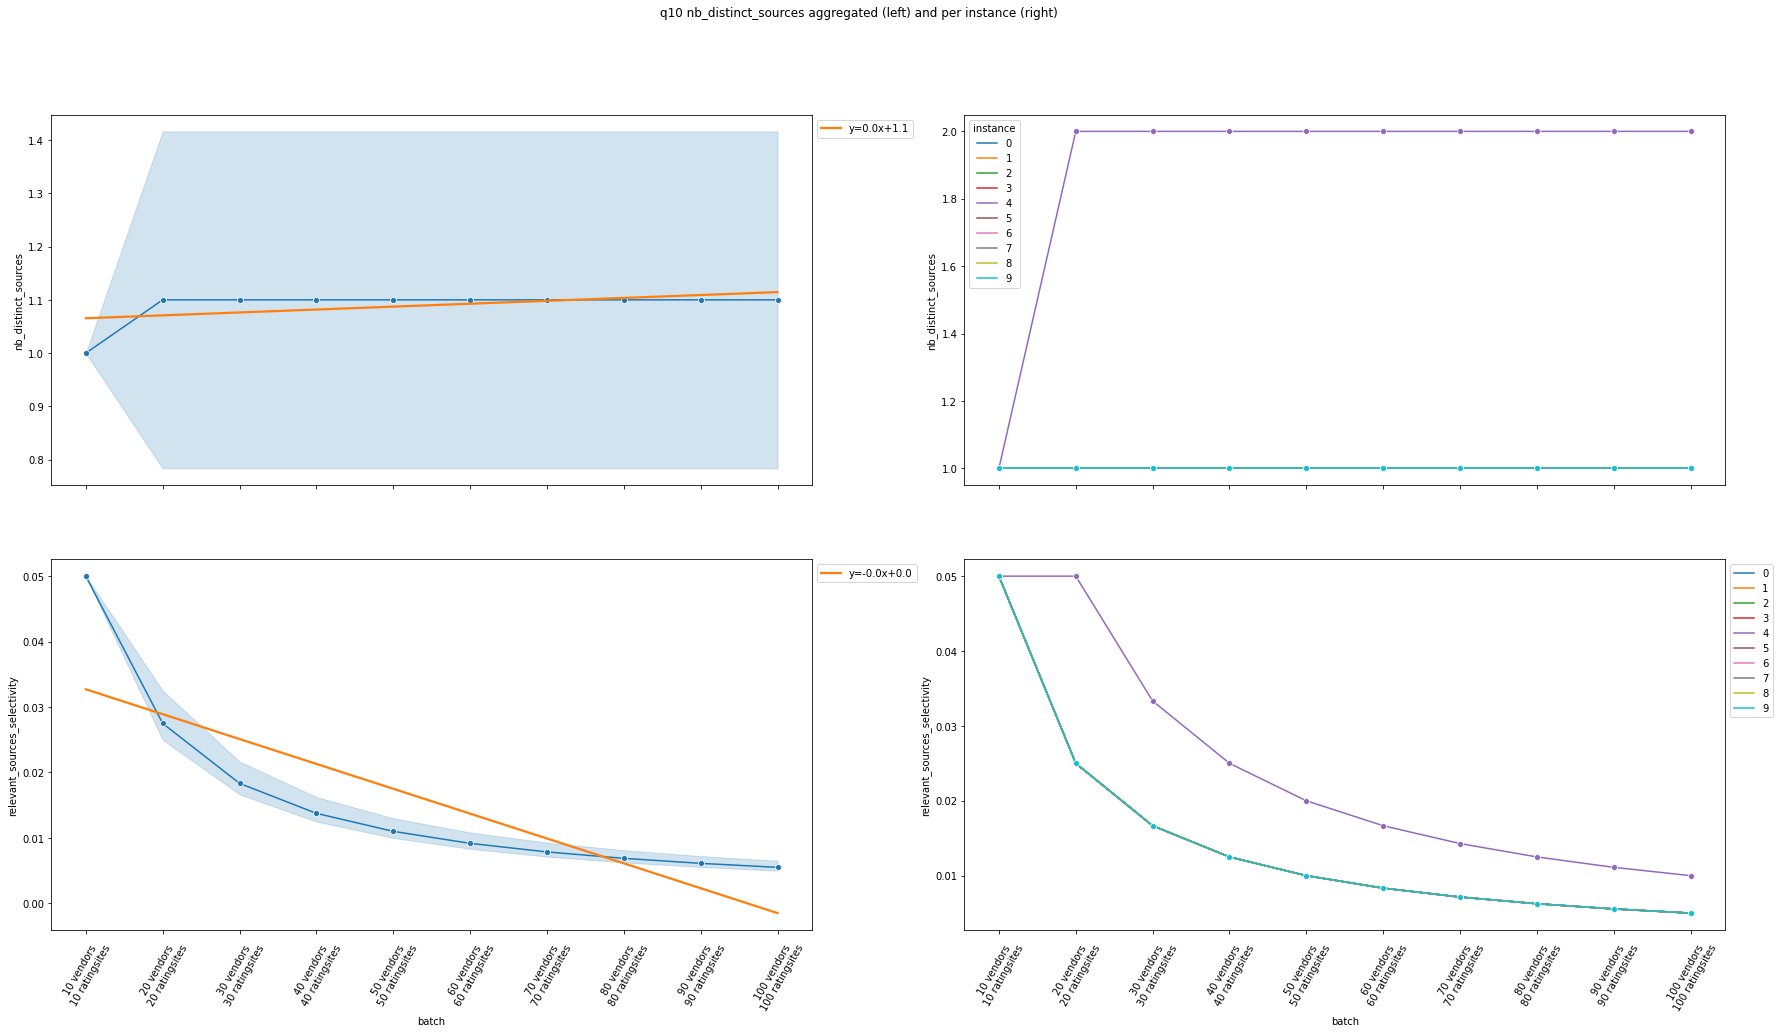

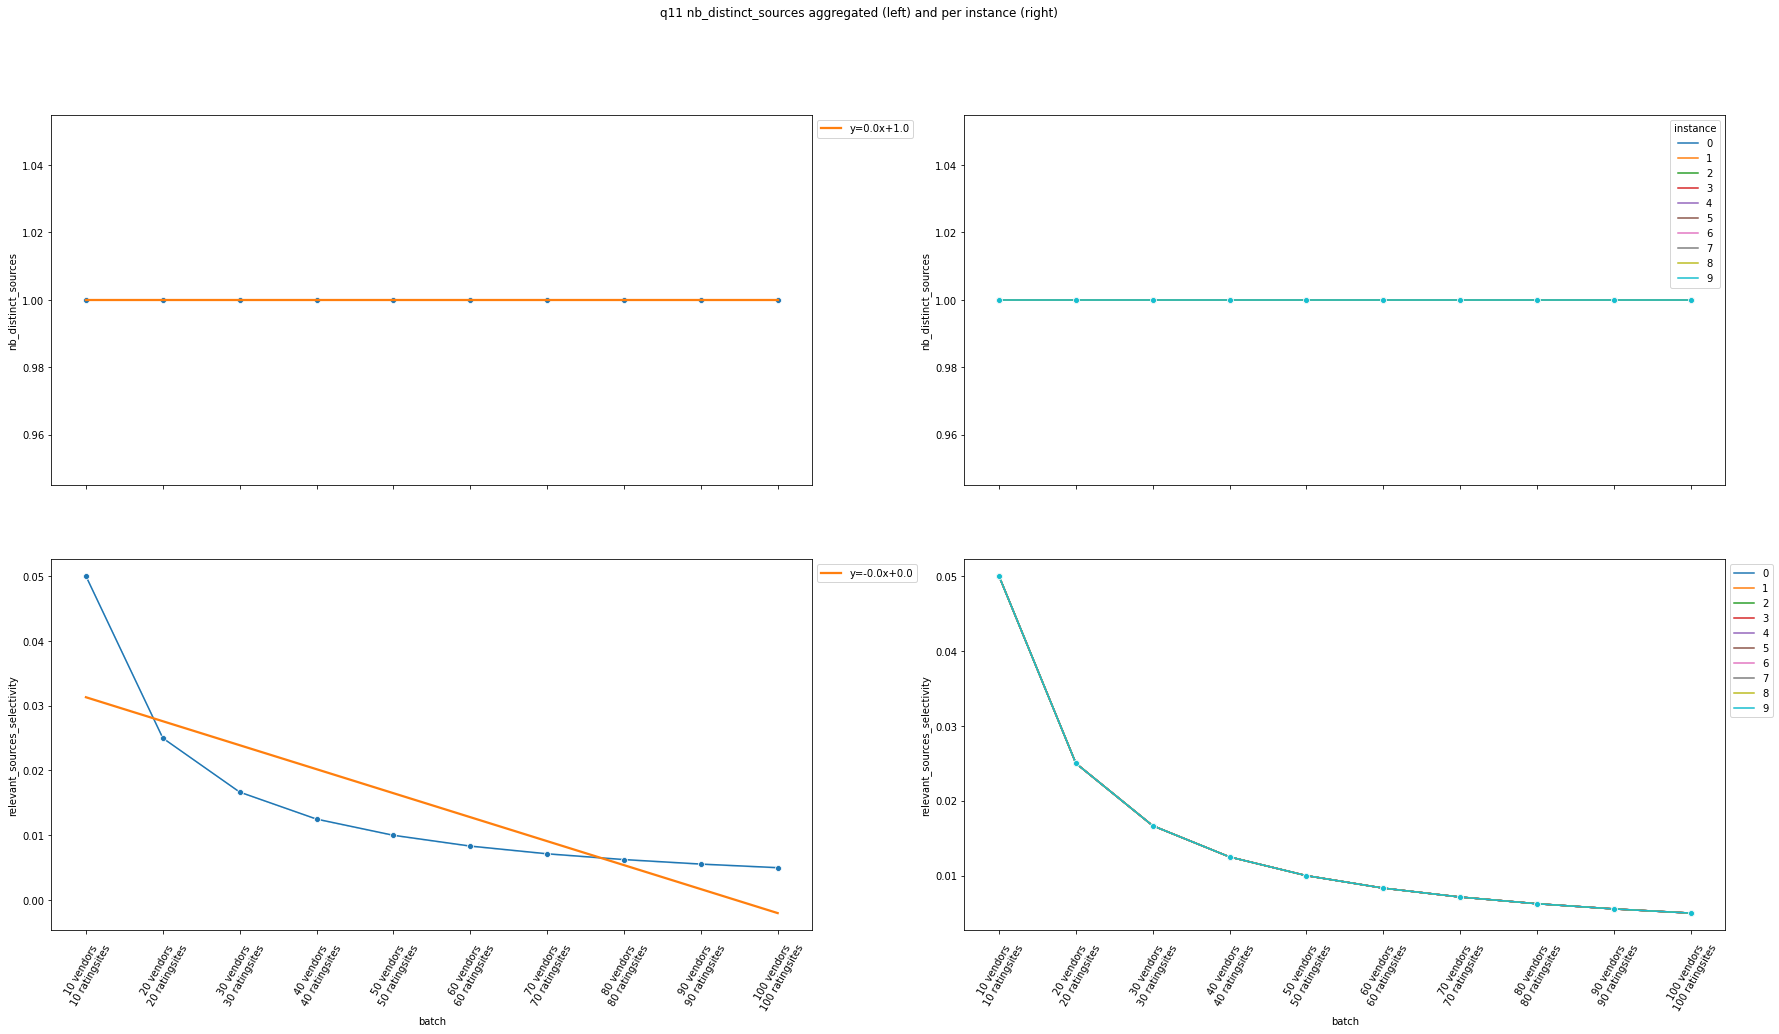

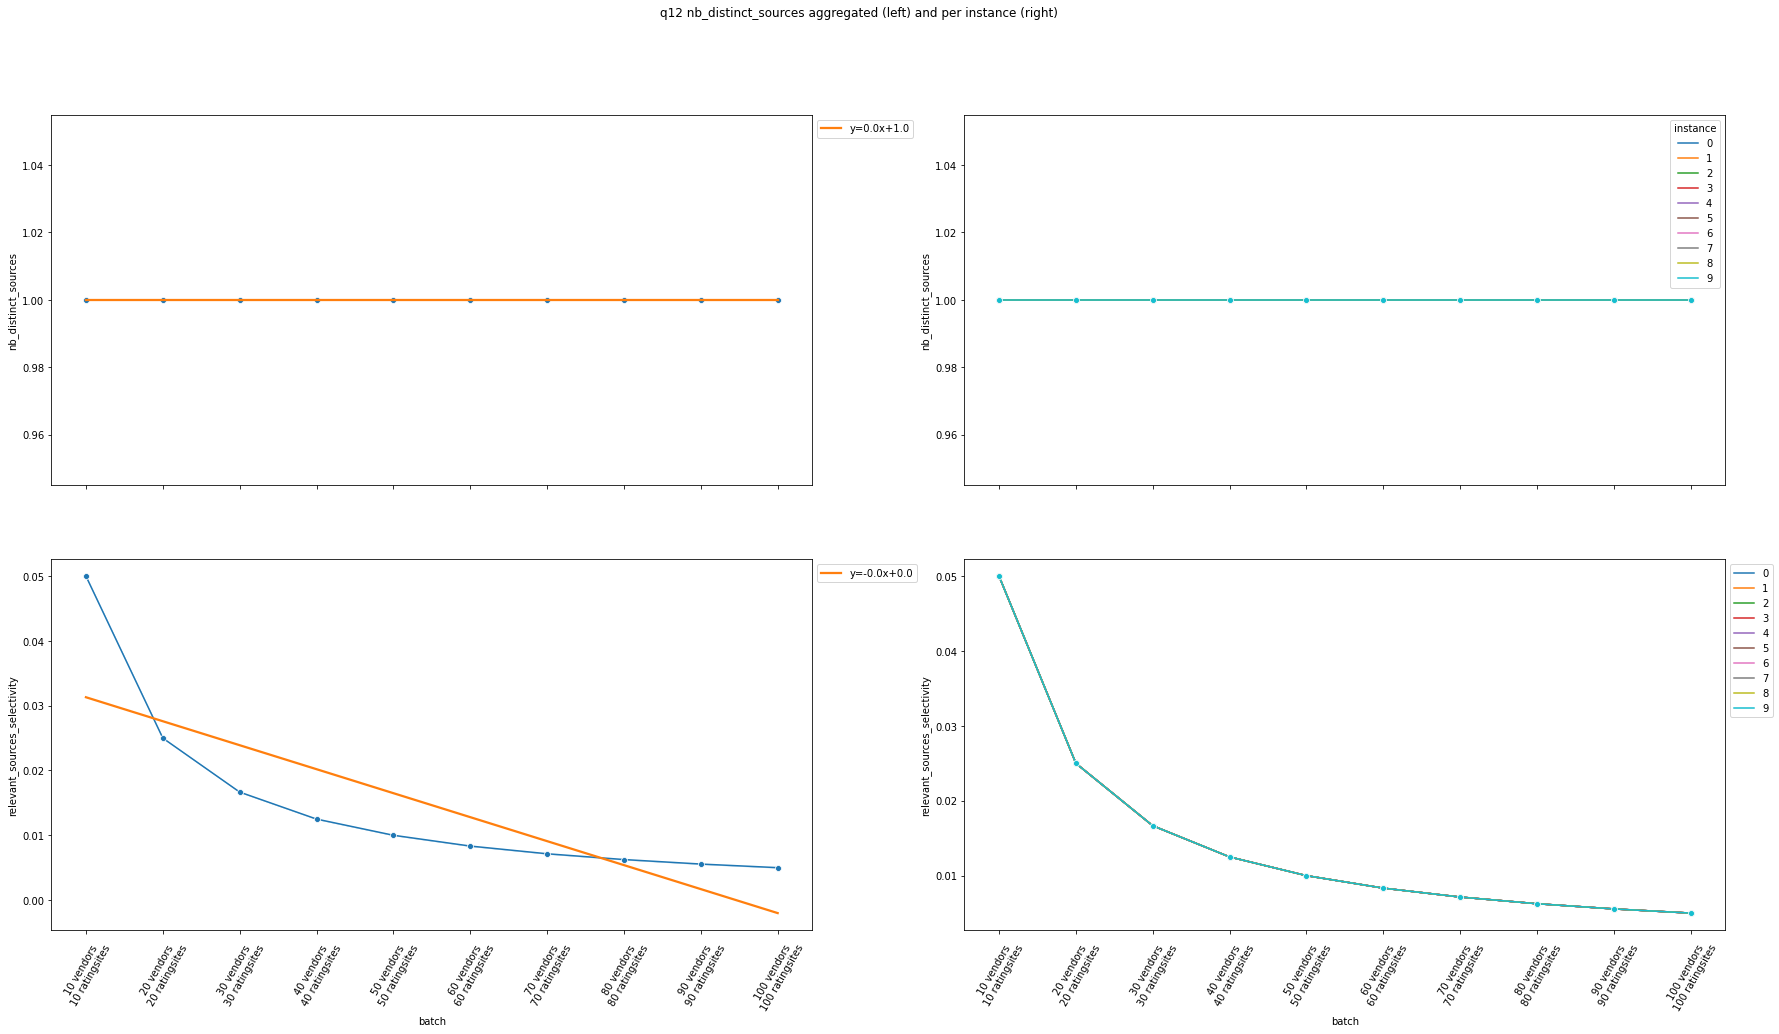

In [ ]:
#@title Line plot showing source selectivity tendency per query template when the number of sources increases

show_total_source_line = False #@param {type:"boolean"}

# n_queries = generation_metrics["query"].nunique()
# fig, axes = plt.subplots(1, n_queries, figsize=(100, 10), sharey=True)
# fig.suptitle('Line plot showing source selectivity tendency per query template when the number of sources increases')

for qid, query in enumerate(generation_metrics["query"].unique()):
    data = generation_metrics.query(f'`query` == {repr(query)}')

    fig, axes = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(30,15))
    fig.suptitle(f"{query} {selectivity_metrics} aggregated (left) and per instance (right) ")

    sns.lineplot(ax=axes[0, 0], data=data, x="batch", y="nb_distinct_sources", markers="o", ci="sd")

    slope, intercept, r_value, p_value, std_err = stats.linregress(data['batch'], data['nb_distinct_sources'])
    sns.regplot(ax=axes[0, 0],
        x="batch", y="nb_distinct_sources", data=data, scatter=False, ci=None,
        label="y={0:.1f}x+{1:.1f}".format(slope,intercept)
    )
    axes[0, 0].legend(loc = 2, bbox_to_anchor = (1,1))

    if show_total_source_line:
        slope, intercept, r_value, p_value, std_err = stats.linregress(data['batch'], data['total_sources'])
        sns.regplot(ax=axes[0, 0],
            x="batch", y="total_sources", data=data, scatter=False, ci=None,
            label="y={0:.1f}x+{1:.1f}".format(slope,intercept)
        )

    axes[0, 0].set_xticks(generation_metrics["batch"].unique())
    axes[0, 0].set_xticklabels(xticks, rotation=60)
    #axes[0, 0].set_yscale("log")
    axes[0, 0].legend(loc = 2, bbox_to_anchor = (1,1))

    sns.lineplot(ax=axes[0, 1], data=data, x="batch", y="nb_distinct_sources", markers="o", hue="instance")
    axes[0, 1].set_xticks(generation_metrics["batch"].unique())
    axes[0, 1].set_xticklabels(xticks, rotation=60)
    #axes[0, 1].set_yscale("log")

    sns.lineplot(ax=axes[1, 0], data=data, x="batch", y="relevant_sources_selectivity", markers="o")
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['batch'], data['relevant_sources_selectivity'])
    sns.regplot(ax=axes[1, 0],
        x="batch", y="relevant_sources_selectivity", data=data, scatter=False, ci=None,
        label="y={0:.1f}x+{1:.1f}".format(slope,intercept)
    )
    axes[1, 0].set_xticks(generation_metrics["batch"].unique())
    axes[1, 0].set_xticklabels(xticks, rotation=60)
    axes[1, 0].legend(loc = 2, bbox_to_anchor = (1,1))
    #axes[1, 0].set_yscale("log")

    sns.lineplot(ax=axes[1, 1], data=data, x="batch", y="relevant_sources_selectivity", markers="o", hue="instance")
    axes[1, 1].set_xticks(generation_metrics["batch"].unique())
    axes[1, 1].set_xticklabels(xticks, rotation=60)
    #axes[1, 1].set_yscale("log")

    plt.legend(loc = 2, bbox_to_anchor = (1,1))
    plt.show()

## Which queries pose challenge to source selection ?

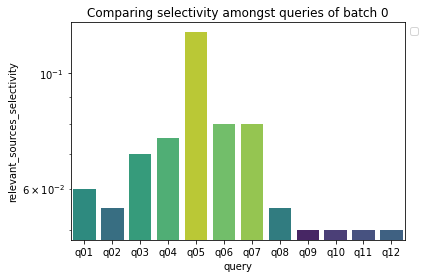

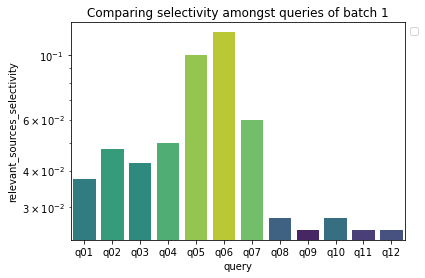

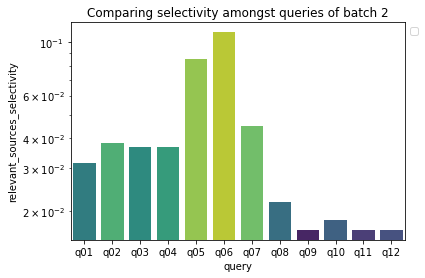

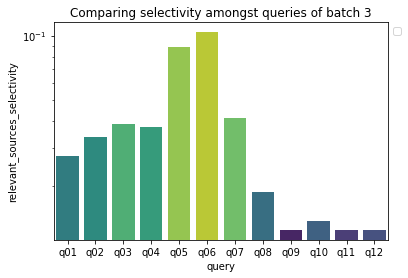

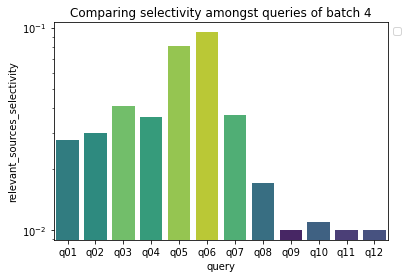

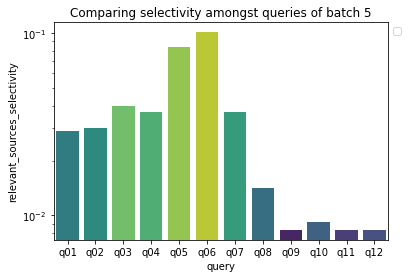

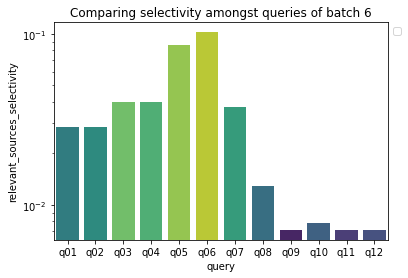

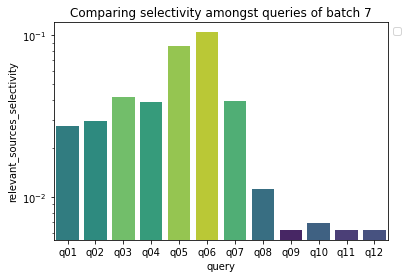

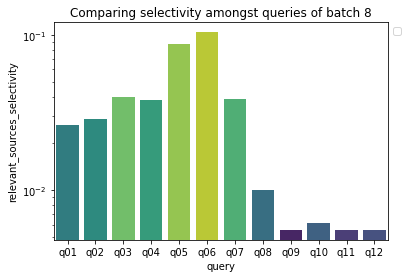

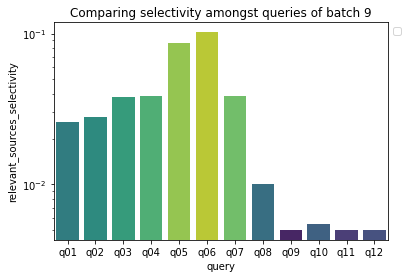

In [ ]:
#@title Bar plot comparing source selectivity amongst queries

#g = sns.barplot(data=generation_metrics, x="query", y="relevant_sources_selectivity")
# plt.show()

for batch in generation_metrics["batch"].unique():
    data = generation_metrics.query(f"`batch` == {repr(batch)}").groupby("query")["relevant_sources_selectivity"].mean()  # data underlying bar plot in question
    pal = sns.color_palette("viridis", n_colors=len(data))
    rank = data.argsort().argsort()  # http://stackoverflow.com/a/6266510/1628638
    g = sns.barplot(x=data.index, y=data, palette=np.array(pal)[rank], ci="sd")
    
    g.set_title(f"Comparing selectivity amongst queries of batch {batch}")
    g.set_yscale("log")
    plt.legend(loc = 2, bbox_to_anchor = (1,1))
    plt.show()

In [ ]:
#@title Ranking of queries by source selectivity across batches (average)
generation_metrics.groupby(["query"])["relevant_sources_selectivity"].mean().sort_values(ascending=False)

query
q06    0.102199
q05    0.090537
q07    0.045382
q03    0.042817
q04    0.042742
q02    0.034942
q01    0.032202
q08    0.019819
q10    0.015609
q09    0.014645
q11    0.014645
q12    0.014645
Name: relevant_sources_selectivity, dtype: float64

# Evaluation

In [ ]:
#@title Use with partial benchmark results
import glob
evaluation_metrics = pd.concat((pd.read_csv(f) for f in glob.glob("/content/benchmark/evaluation/metrics_batch*.csv")))

In [ ]:
#@title Execute with complete benchmark results
evaluation_metrics = pd.read_csv("/content/benchmark/evaluation/metrics.csv")
evaluation_metrics

In [ ]:
#@title Post-processing

n_attempts = evaluation_metrics['attempt'].nunique()
n_instances = evaluation_metrics['instance'].nunique()
n_batches = evaluation_metrics['batch'].nunique()

def scoring(x):
    vc = x.value_counts(normalize=False) / (n_attempts*n_instances*n_batches) # 4 attempts x 10 instances x 10 batches
    #return vc["success"] if vc.index.str.contains("success").any() else 0
    return list(vc.iteritems())

evaluation_metrics.drop(["http_req"], axis=1, inplace=True)
evaluation_metrics["success_rate"] = evaluation_metrics["exec_time"].astype(str).str.replace(r"(\d+)(\.\d+)?", "success", regex=True)
evaluation_metrics["exec_time"] = pd.to_numeric(evaluation_metrics["exec_time"].astype(str).str.replace("(error.*|timeout)", str(np.nan), regex=True), errors="coerce")
#evaluation_metrics["http_req"] = pd.to_numeric(evaluation_metrics["http_req"].str.replace("(error.*|timeout)", str(np.nan), regex=True), errors="coerce")

#evaluation_metrics.dropna(inplace=True)
evaluation_metrics.fillna(600000, inplace=True)

evaluation_metrics["instance"] = evaluation_metrics["instance"].astype(str)
evaluation_metrics["qid"] = evaluation_metrics["query"].str.extract(r"q(\d+)").astype(int)
evaluation_metrics.sort_values(by=["qid", "instance", "batch"], inplace=True)

#evaluation_metrics = evaluation_metrics.query("`engine` == 'arq'")

evaluation_metrics.reset_index(drop=True, inplace=True)

status_df = evaluation_metrics \
    .groupby(["engine", "query"])["success_rate"] \
    .aggregate(scoring).to_frame("status").reset_index()

status_df = status_df.explode("status")
status_df[["status", "freq"]] = pd.DataFrame(status_df["status"].to_list(), index=status_df.index)


In [ ]:
evaluation_metrics.query("`engine` == 'costfed'").groupby(["batch"])["exec_time"].describe()

ValueError: ignored

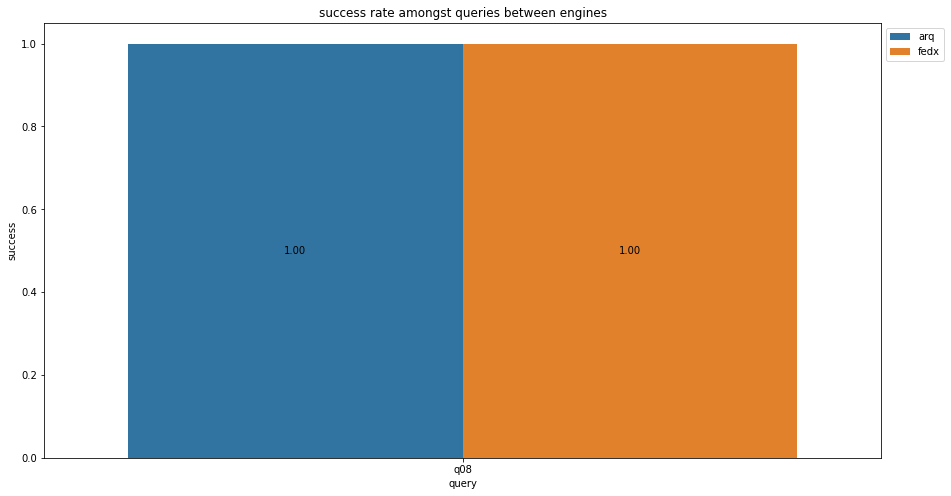

In [ ]:
#@title Engines performance (success rate, failture rate per category)

for status_code in status_df["status"].unique():
    fig, ax = plt.subplots(figsize=(15, 8))

    g = sns.barplot(ax=ax, data=status_df.query(f"`status` == {repr(status_code)}"), x="query", y="freq", ci=None, hue="engine")
    g.set_title(f"{status_code} rate amongst queries between engines")
    g.set_ylabel(status_code)

    for container_id in range(len(ax.containers)):
        ax.bar_label(ax.containers[container_id], fmt='%.2f', label_type='center')

    plt.legend(loc = 2, bbox_to_anchor = (1,1))
    plt.show()

In [ ]:
_, vendors_labels = np.histogram(np.arange(100), evaluation_metrics["batch"].nunique())
vendors_labels = vendors_labels[1:].astype(int) + 1

_, ratingsite_labels = np.histogram(np.arange(100), evaluation_metrics["batch"].nunique())
ratingsite_labels = ratingsite_labels[1:].astype(int) + 1

xticks = [ f"{vendor} vendors\n{ratingsite} ratingsites" for vendor, ratingsite in zip(vendors_labels, ratingsite_labels) ]

In [ ]:
!pip install --upgrade seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 KB 7.7 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


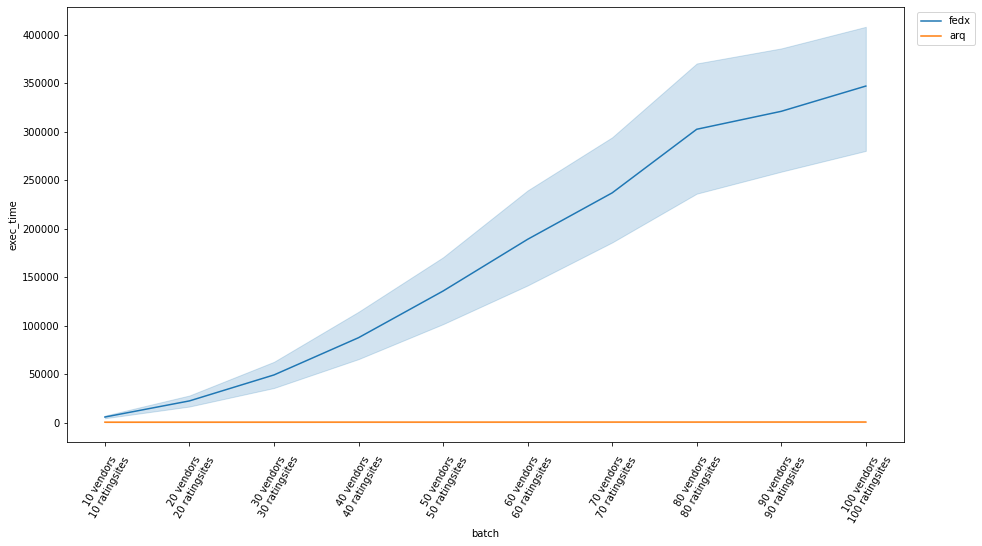

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.figure(figsize=(15,8))

g = sns.lineplot(data=evaluation_metrics, x="batch", y="exec_time", hue="engine")
g.set_yscale("linear")
g.set_xticks(evaluation_metrics["batch"].unique())
g.set_xticklabels(xticks, rotation=60)

plt.legend(loc = 2, bbox_to_anchor = (1.01,1))
plt.show()

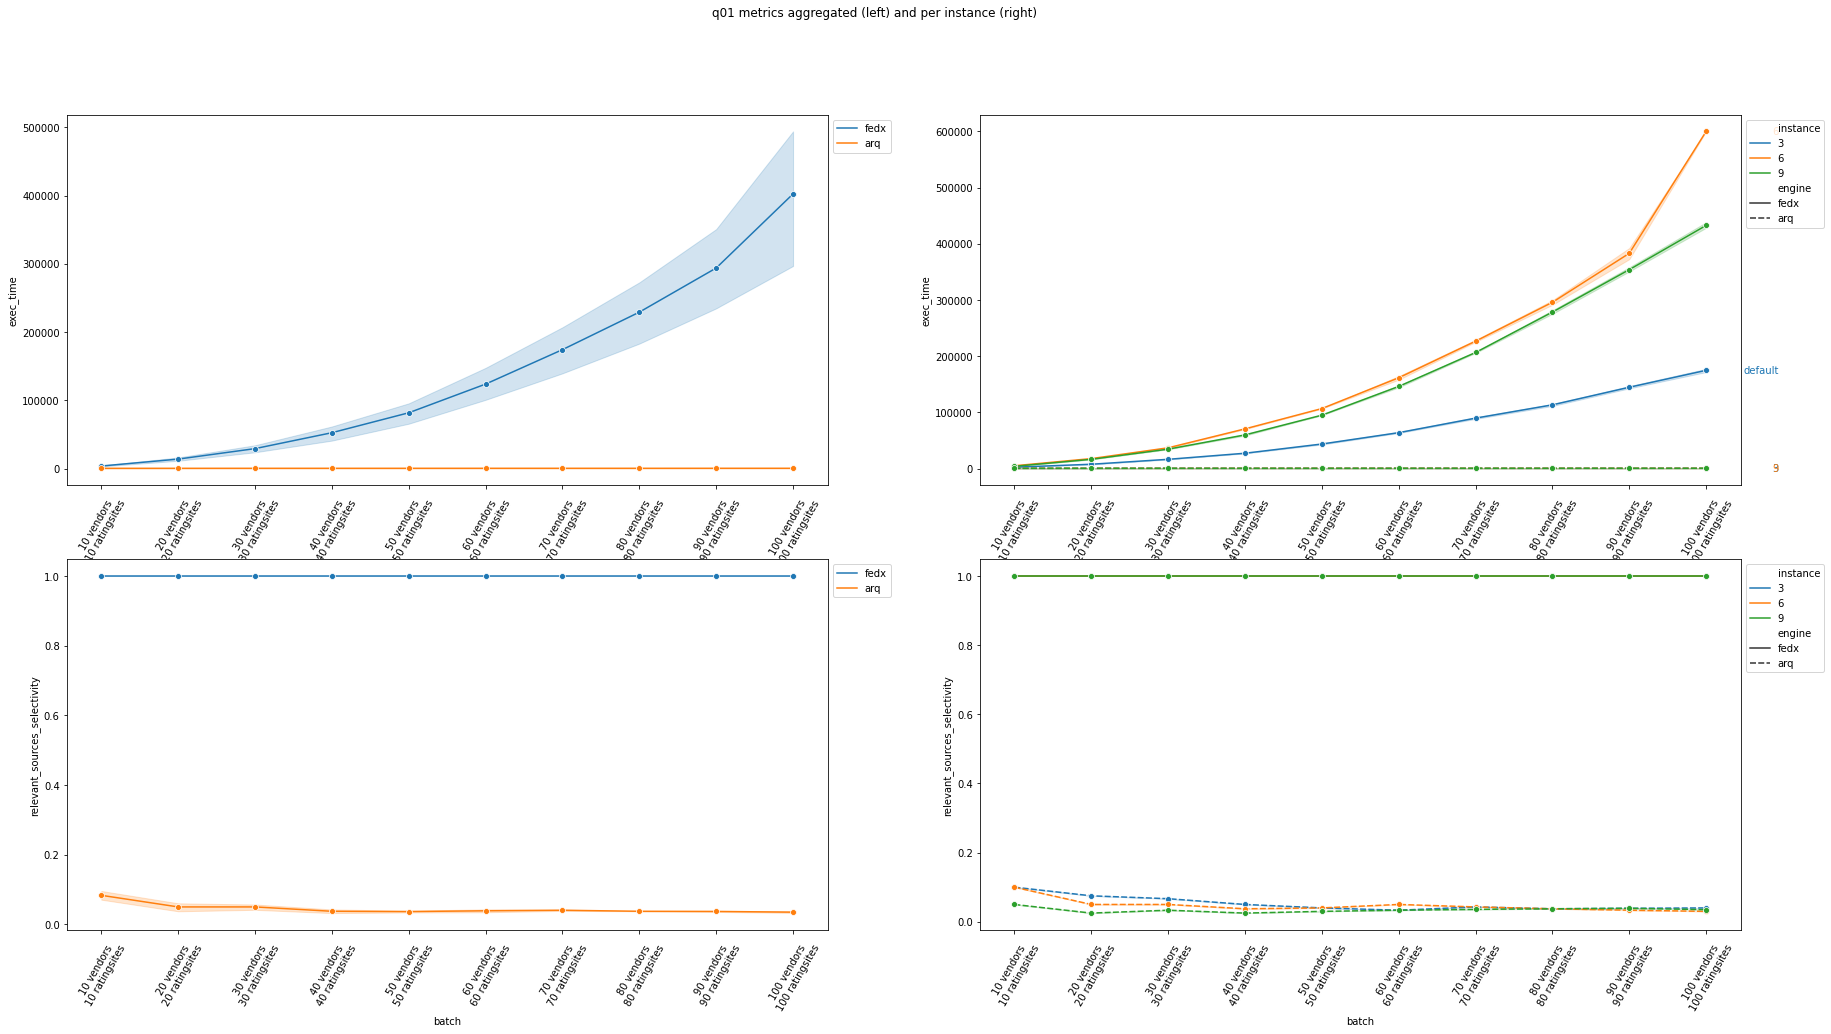

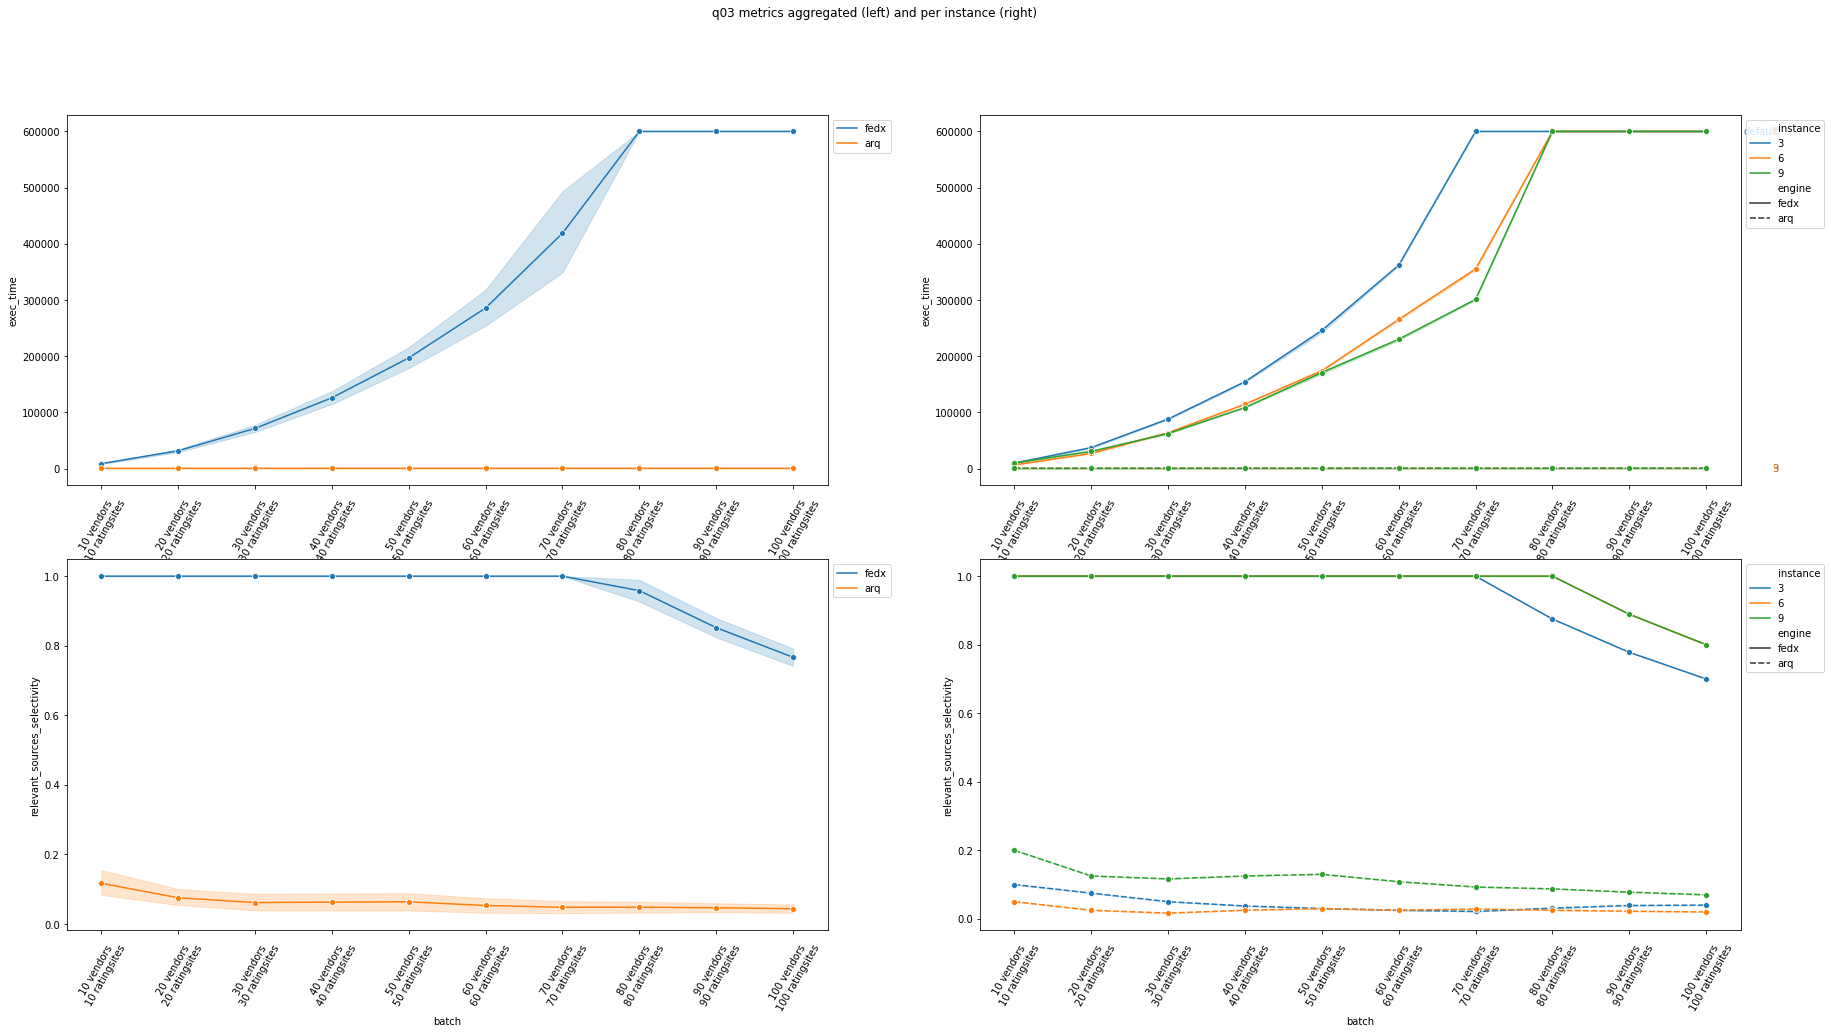

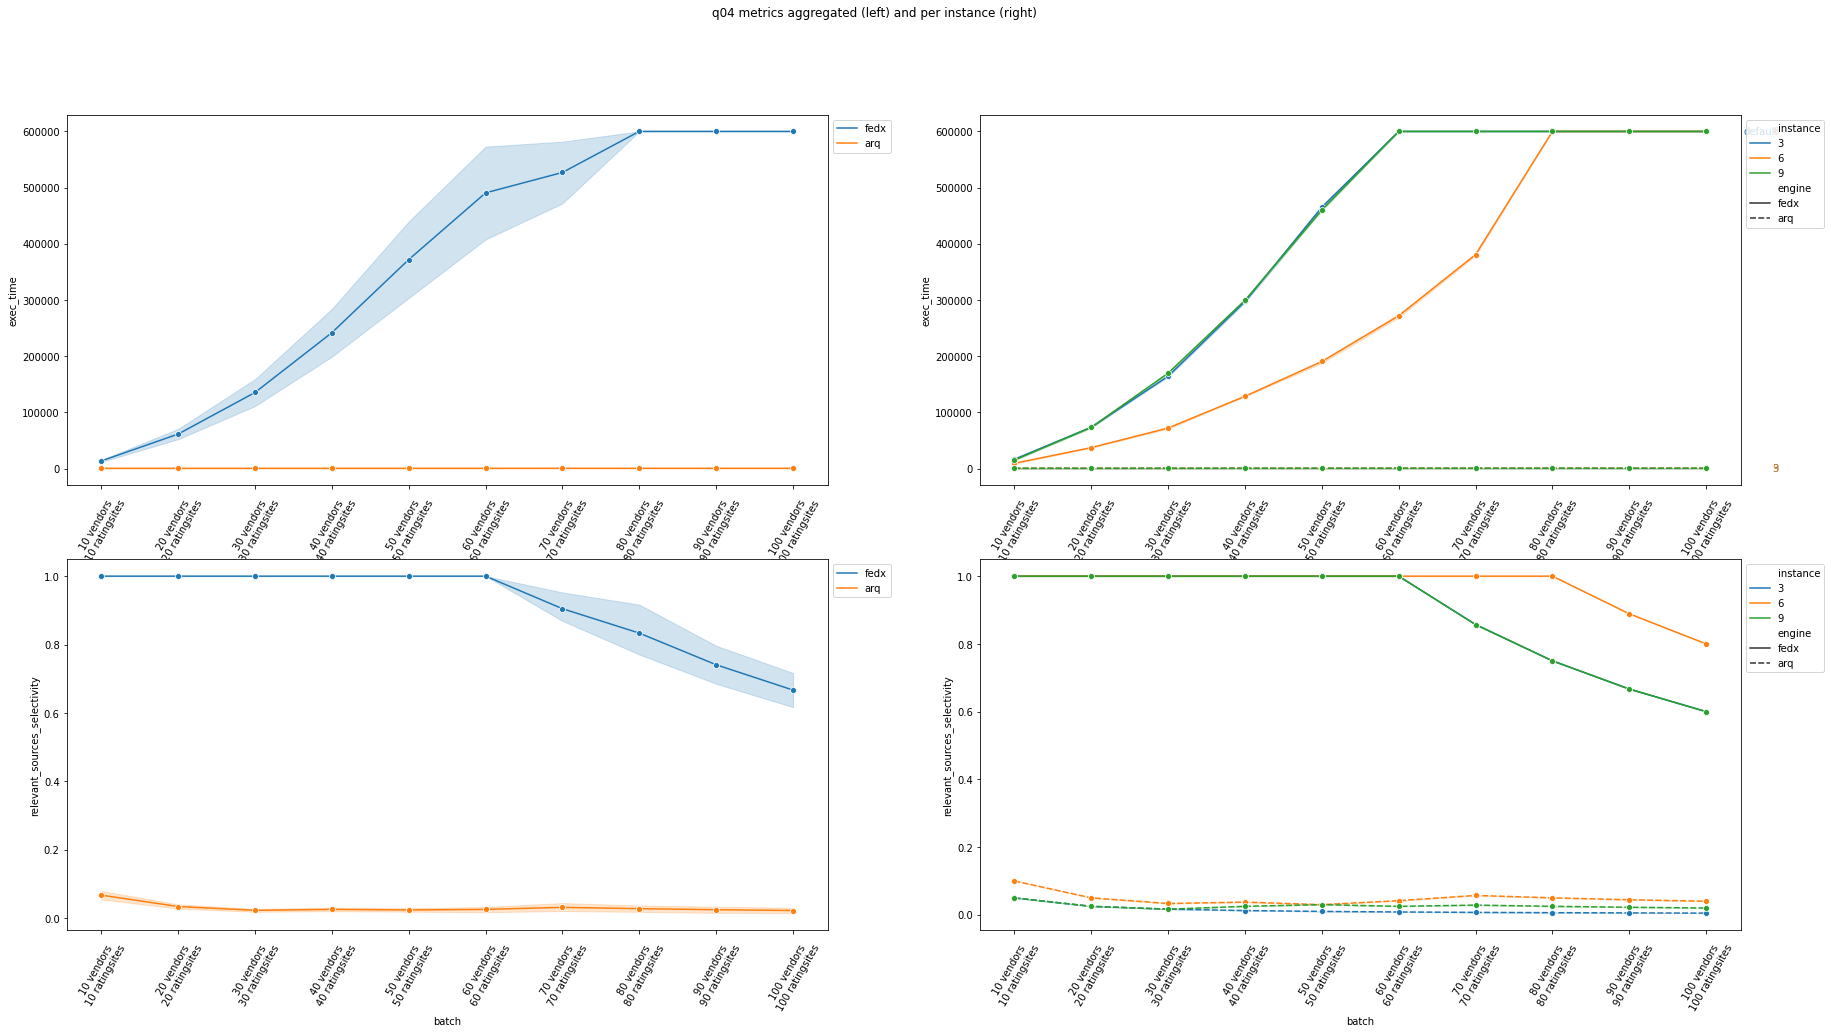

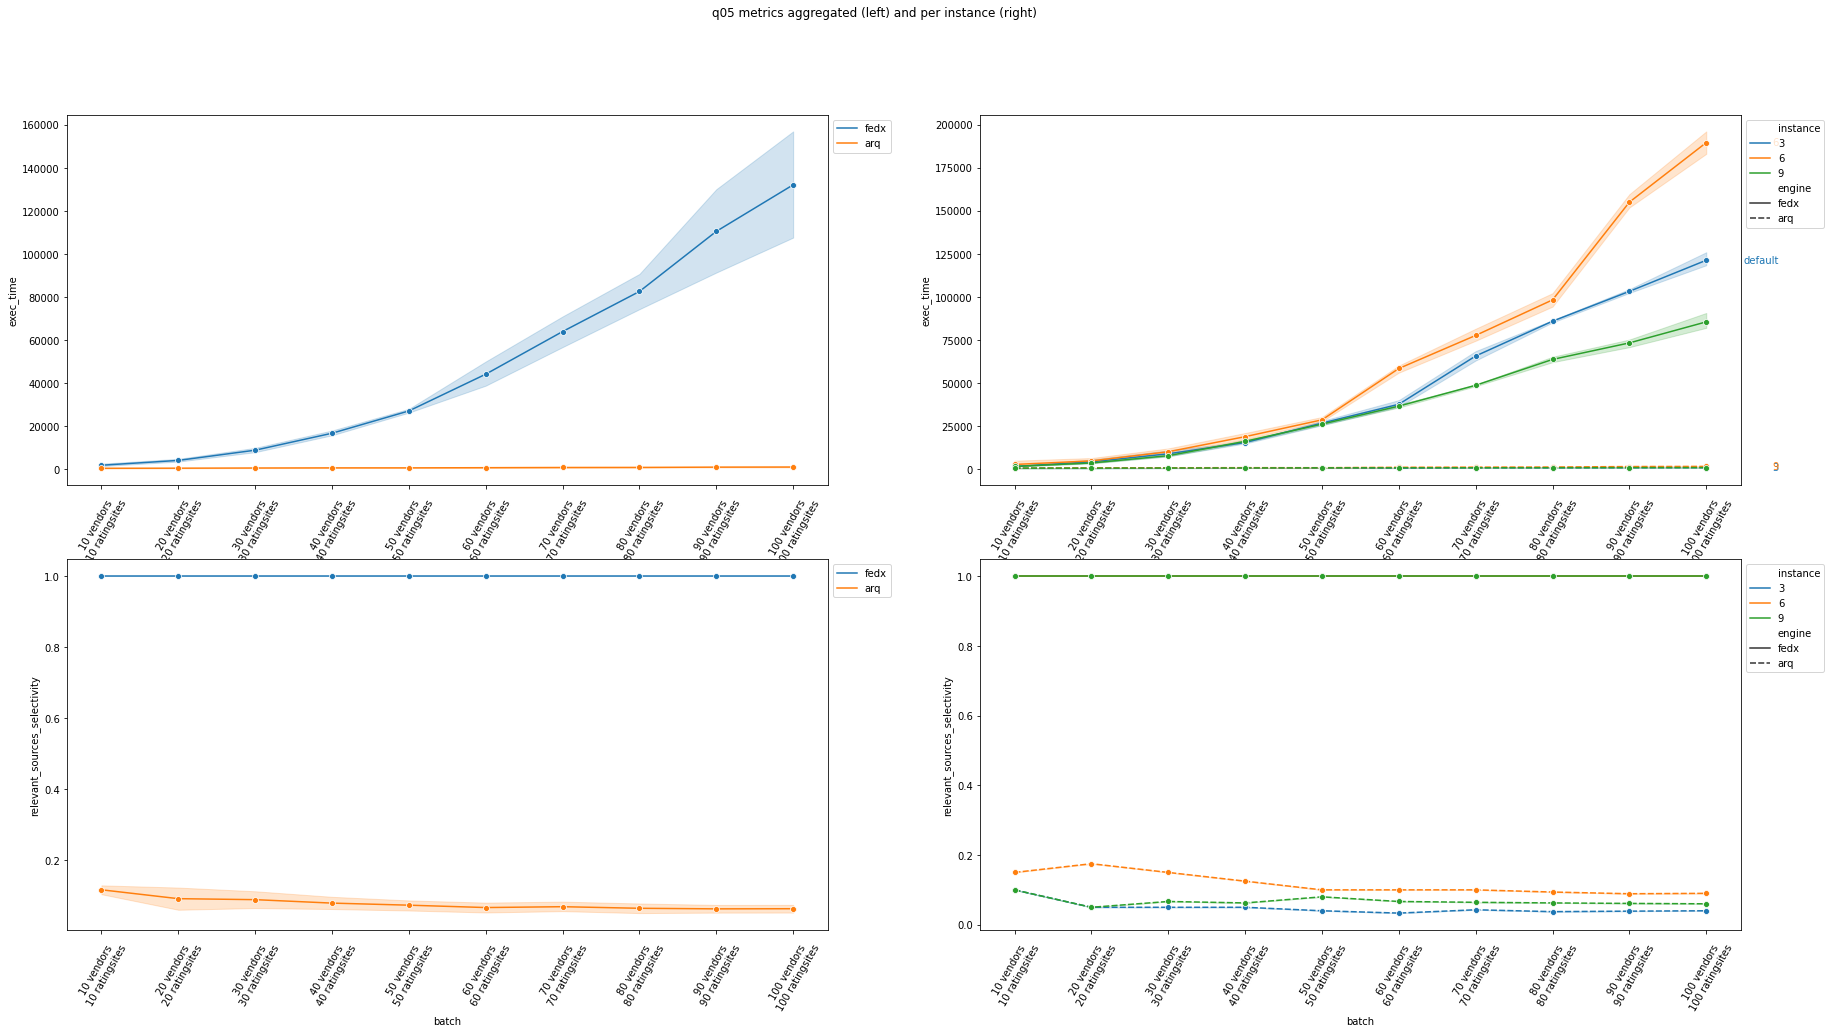

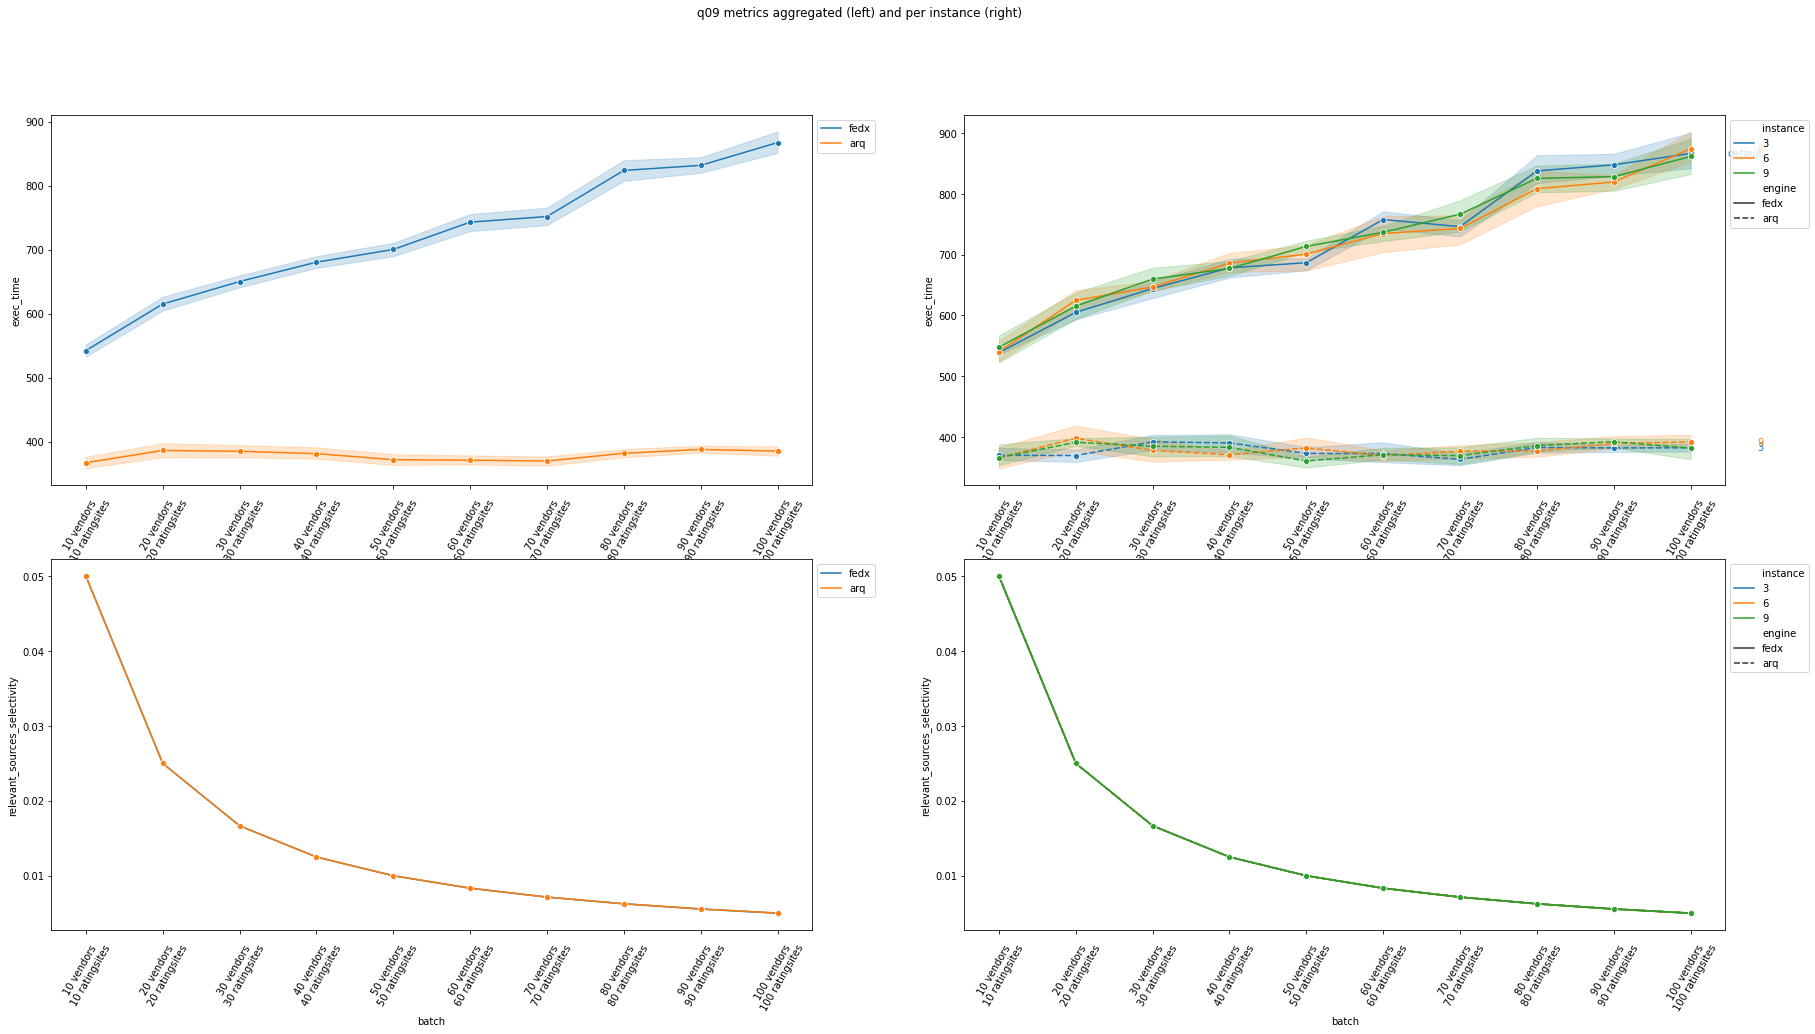

In [ ]:
#@title Line plot showing source selectivity tendency per query template when the number of sources increases

scale = "linear" #@param ["linear", "log"]

# n_queries = evaluation_metrics["query"].nunique()
# fig, axes = plt.subplots(1, n_queries, figsize=(100, 10), sharey=True)
# fig.suptitle('Line plot showing source selectivity tendency per query template when the number of sources increases')

for qid, query in enumerate(evaluation_metrics["query"].unique()):
    data = evaluation_metrics.query(f'`query` == {repr(query)}')

    fig, axes = plt.subplots(2, 2, figsize=(30,15))
    fig.suptitle(f"{query} metrics aggregated (left) and per instance (right) ")

    sns.lineplot(ax=axes[0, 0], data=data, x="batch", y="exec_time", markers="o", hue="engine")
    axes[0, 0].set_xticks(evaluation_metrics["batch"].unique())
    axes[0, 0].set_xticklabels(xticks, rotation=60)
    axes[0, 0].set_yscale(scale)
    axes[0, 0].legend(loc = 2, bbox_to_anchor = (1,1))

    sns.lineplot(ax=axes[0, 1], data=data, x="batch", y="exec_time", markers="o", hue="engine", styles="instance")
    axes[0, 1].set_xticks(evaluation_metrics["batch"].unique())
    axes[0, 1].set_xticklabels(xticks, rotation=60)
    axes[0, 1].set_yscale(scale)
    lines_labels = ["default"] + data["instance"].unique().tolist()
    for l, label in zip(axes[0, 1].lines, lines_labels):
        y = l.get_ydata()
        if len(y)>0:
            axes[0, 1].annotate(label, xy=(1.05,y[-1]), xycoords=('axes fraction', 'data'), 
                        ha='right', va='center', color=l.get_color())
    axes[0, 1].legend(loc = 2, bbox_to_anchor = (1,1))

    sns.lineplot(ax=axes[1, 0], data=data, x="batch", y="relevant_sources_selectivity", markers="o", hue="engine")
    axes[1, 0].set_xticks(evaluation_metrics["batch"].unique())
    axes[1, 0].set_xticklabels(xticks, rotation=60)
    axes[1, 0].legend(loc = 2, bbox_to_anchor = (1,1))
    axes[1, 0].set_yscale(scale)

    sns.lineplot(ax=axes[1, 1], data=data, x="batch", y="relevant_sources_selectivity", markers="o", style="engine", hue="instance")
    axes[1, 1].set_xticks(evaluation_metrics["batch"].unique())
    axes[1, 1].set_xticklabels(xticks, rotation=60)
    axes[1, 1].set_yscale(scale)

    plt.legend(loc = 2, bbox_to_anchor = (1,1))
    plt.show()

# Other experiments

## Hypergraph

In [ ]:
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import networkx as nx
G = nx.MultiDiGraph()

G.add_node("tp1", name="tp1", color="orange")
G.add_node("tp2", name="tp2", color="orange")
G.add_node("tp3_tp9", name="tp3_tp9", color="red")
G.add_node("tp4", name="tp4", color="orange")
G.add_node("tp5", name="tp5", color="orange")
G.add_node("tp6", name="tp6", color="orange")
G.add_node("tp7", name="tp7", color="orange")
G.add_node("tp8", name="tp8", color="orange")
G.add_node("tp10", name="tp10", color="orange")
G.add_node("tp11", name="tp11", color="orange")
G.add_node("S1", name="S1", color="blue")
G.add_node("S2", name="S2", color="blue")

cmap = []
for node in G:
    if node in ["S1", "S2"]:
        cmap.append("blue")
    elif node == "tp3_tp9":
        cmap.append("red")
    else:
        cmap.append("orange")

# First part

G.add_edge("S1", "tp1", weight=2, source="v0")
G.add_edge("S1", "tp1", weight=2, source="r7")

G.add_edge("S1", "tp2", weight=2, source="v0")
G.add_edge("S1", "tp2", weight=2, source="r7")

G.add_edge("S1", "tp4", weight=2, source="v0")
G.add_edge("S1", "tp4", weight=2, source="r7")

G.add_edge("S1", "tp5", weight=2, source="v0")
G.add_edge("S1", "tp5", weight=2, source="r7")

G.add_edge("S1", "tp3_tp9", weight=2, source="v0")
G.add_edge("S1", "tp3_tp9", weight=2, source="r7")

# Second part

G.add_edge("S2", "tp6", weight=2, source="v3")
G.add_edge("S2", "tp6", weight=2, source="r12")

G.add_edge("S2", "tp7", weight=2, source="v3")
G.add_edge("S2", "tp7", weight=2, source="r12")

G.add_edge("S2", "tp8", weight=2, source="v3")
G.add_edge("S2", "tp8", weight=2, source="r12")

G.add_edge("S2", "tp10", weight=2, source="v3")
G.add_edge("S2", "tp10", weight=2, source="r12")

G.add_edge("S2", "tp11", weight=2, source="v3")
G.add_edge("S2", "tp11", weight=2, source="r12")

G.add_edge("S2", "tp3_tp9", weight=2, source="v3")
G.add_edge("S2", "tp3_tp9", weight=2, source="r12")

1

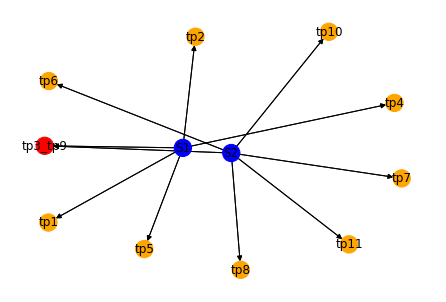

In [ ]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=cmap, with_labels=True)

In [ ]:
#@title Community
import networkx.algorithms.community as nx_comm
communities = nx_comm.louvain_communities(G)
communities

[{'S1', 'tp1', 'tp2', 'tp3_tp9', 'tp4', 'tp5'},
 {'S2', 'tp10', 'tp11', 'tp6', 'tp7', 'tp8'}]

In [ ]:
nx.hits(G)

({'tp1': -0.0,
  'tp2': -0.0,
  'tp3_tp9': -0.0,
  'tp4': -0.0,
  'tp5': -0.0,
  'tp6': -0.0,
  'tp7': -0.0,
  'tp8': -0.0,
  'tp10': -0.0,
  'tp11': -0.0,
  'S1': 0.3819660112501052,
  'S2': 0.6180339887498948},
 {'tp1': 0.06798926671055953,
  'tp2': 0.06798926671055953,
  'tp3_tp9': 0.1779982111184266,
  'tp4': 0.06798926671055953,
  'tp5': 0.0679892667105595,
  'tp6': 0.11000894440786707,
  'tp7': 0.11000894440786707,
  'tp8': 0.11000894440786707,
  'tp10': 0.11000894440786707,
  'tp11': 0.11000894440786706,
  'S1': -0.0,
  'S2': 1.1542541016787126e-18})